In [1]:
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.datasets import ImageFolder
import numpy as np
from torchvision import transforms, models
from PIL import Image
import os
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.transforms
import numpy as np




In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
data_dir = '/kaggle/input/d/proggaparmita/ecg-image-dataset/ECG Image dataset for Myocardial Infarction Compli/Jay_Prakash_Maurya'


Abnormal heartbeat_ECG Images: 233 images
Myocardial Infarction Patients: 239 images
ECG Images of Patient that have History of MI: 172 images
Normal_ECG Images: 284 images


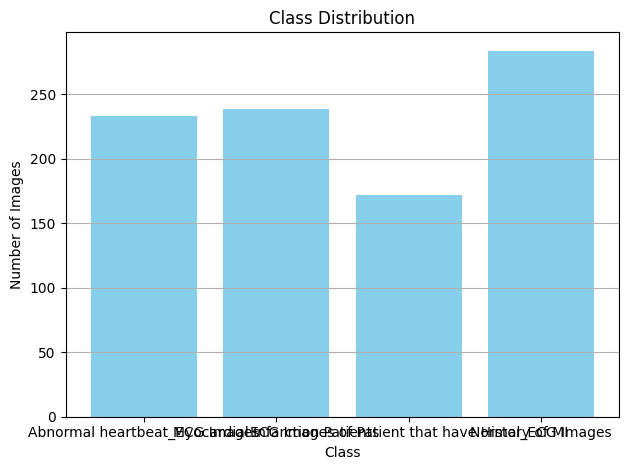

In [5]:
import os
import matplotlib.pyplot as plt

# Path to your dataset
data_dir = '/kaggle/input/d/proggaparmita/ecg-image-dataset/ECG Image dataset for Myocardial Infarction Compli/Jay_Prakash_Maurya'

# Count images per class
class_counts = {}
for cls in os.listdir(data_dir):
    cls_path = os.path.join(data_dir, cls)
    if os.path.isdir(cls_path):
        class_counts[cls] = len(os.listdir(cls_path))

# Print counts
for cls, count in class_counts.items():
    print(f"{cls}: {count} images")

# Bar plot
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [6]:
class ECGDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
def load_and_preprocess_data(data_dir, target_size=(224, 224)):
    classes = ['Abnormal heartbeat_ECG Images', 'Myocardial Infarction Patients' , 'ECG Images of Patient that have History of MI' , "Normal_ECG Images"]
    image_paths = []
    labels = []

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            image_paths.append(img_path)
            labels.append(i)

    return image_paths, np.array(labels)

# Separate function for loading and resizing images on-demand
def load_image(img_path, target_size=(224, 224)):
    img = Image.open(img_path).convert('RGB')
    img = img.resize(target_size)
    return img

In [8]:
from torchvision.datasets import ImageFolder
from collections import Counter

dataset = ImageFolder(root='/kaggle/input/d/proggaparmita/ecg-image-dataset/ECG Image dataset for Myocardial Infarction Compli/Jay_Prakash_Maurya')
labels = [label for _, label in dataset]
class_counts = Counter(labels)

print(class_counts)

# Optional: map class indices to names
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
print({idx_to_class[i]: count for i, count in class_counts.items()})

Counter({3: 284, 2: 239, 0: 233, 1: 172})
{'Abnormal heartbeat_ECG Images': 233, 'ECG Images of Patient that have History of MI': 172, 'Myocardial Infarction Patients': 239, 'Normal_ECG Images': 284}


In [9]:
# Usage:
image_paths, y = load_and_preprocess_data(data_dir)
# Load images only as needed
X = [load_image(img_path) for img_path in image_paths]

In [10]:
from sklearn.model_selection import train_test_split

def split_data(X, y, test_size=0.2, val_size=0.1, random_state=42):
    # Split into train+val and test
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Calculate validation size relative to the temp set
    val_relative_size = val_size / (1 - test_size)
    
    # Split temp into train and val
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_relative_size, random_state=random_state)
    
    return X_train, X_val, X_test, y_train, y_val, y_test


In [11]:
# Split data
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

print(f'X_train length: {len(X_train)}')
print(f'X_val length: {len(X_val)}')
print(f'X_test length: {len(X_test)}')

X_train length: 649
X_val length: 93
X_test length: 186


In [12]:
# Define transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = ECGDataset(X_train, y_train, transform=transform_train)
val_dataset = ECGDataset(X_val, y_val, transform=transform_val_test)
test_dataset = ECGDataset(X_test, y_test, transform=transform_val_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

**Resnet152**

**XceptionNet**

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 1. Depthwise Separable Convolution
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(
            in_channels, in_channels, kernel_size=kernel_size,
            stride=stride, padding=padding, groups=in_channels, bias=bias
        )
        self.pointwise = nn.Conv2d(
            in_channels, out_channels, kernel_size=1, bias=bias
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return self.bn(x)

In [14]:
# 2. Xception Residual Block
class XceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, reps=3, stride=1, grow_first=True):
        super(XceptionBlock, self).__init__()
        self.skip = nn.Identity()
        if in_channels != out_channels or stride != 1:
            self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)

        layers = []
        filters = in_channels
        if grow_first:
            layers.append(nn.ReLU(inplace=True))
            layers.append(SeparableConv2d(in_channels, out_channels))
            filters = out_channels

        for _ in range(reps - 1):
            layers.append(nn.ReLU(inplace=True))
            layers.append(SeparableConv2d(filters, filters))

        if stride != 1:
            layers.append(nn.MaxPool2d(kernel_size=3, stride=stride, padding=1))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x) + self.skip(x)


In [15]:
# 3. Full Xception-Style Model
class CustomXceptionCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomXceptionCNN, self).__init__()

        # Entry flow
        self.entry = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Middle flow
        self.middle = nn.Sequential(
            XceptionBlock(64, 128, reps=2, stride=2),
            XceptionBlock(128, 256, reps=2, stride=2),
            XceptionBlock(256, 728, reps=3, stride=2)
        )

        # Exit flow
        self.exit = nn.Sequential(
            nn.ReLU(inplace=True),
            SeparableConv2d(728, 1024),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.entry(x)
        x = self.middle(x)
        x = self.exit(x)
        return x



In [16]:


# Training function with tqdm
def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, n_epochs=50, patience=10):
    import numpy as np
    import torch
    from tqdm import tqdm

    # ✅ Define device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    N_test = len(val_loader.dataset)
    N_train = len(train_loader.dataset)
    train_accuracy_list = []
    val_accuracy_list = []
    train_cost_list = []
    val_cost_list = []

    val_loss_min = np.Inf
    patience_counter = 0

    for epoch in range(n_epochs):
        model.train()
        train_cost = 0.0
        train_correct = 0

        for x_train, y_train in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{n_epochs}", unit="batch"):
            # ✅ Move data to device
            x_train, y_train = x_train.to(device), y_train.to(device)

            optimizer.zero_grad()
            outputs = model(x_train)
            train_loss = criterion(outputs, y_train)
            _, yhat = outputs.max(1)
            train_correct += (yhat == y_train).sum().item()
            train_loss.backward()
            optimizer.step()
            train_cost += train_loss.item()

        train_cost /= len(train_loader)
        train_cost_list.append(train_cost)

        train_accuracy = train_correct / N_train
        train_accuracy_list.append(train_accuracy)

        # Validation
        model.eval()
        val_cost = 0.0
        val_correct = 0

        with torch.no_grad():
            for x_test, y_test in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{n_epochs} [val]", unit="batch"):
                # ✅ Move data to device
                x_test, y_test = x_test.to(device), y_test.to(device)

                outputs_test = model(x_test)
                val_loss = criterion(outputs_test, y_test)
                _, yhat = outputs_test.max(1)
                val_correct += (yhat == y_test).sum().item()
                val_cost += val_loss.item()

        val_cost /= len(val_loader)
        val_cost_list.append(val_cost)

        val_accuracy = val_correct / N_test
        val_accuracy_list.append(val_accuracy)

        print(f"--> Epoch {epoch + 1} | Train Loss: {train_cost:.4f} | Val Loss: {val_cost:.4f} | Train Acc: {train_accuracy * 100:.2f}% | Val Acc: {val_accuracy * 100:.2f}%")

        # Step the scheduler
        scheduler.step(val_cost)

        if val_cost < val_loss_min:
            print(f'Validation loss decreased ({val_loss_min:.6f} → {val_cost:.6f}). Saving model ...')
            torch.save(model.state_dict(), 'model_Custom_xception.pt')
            val_loss_min = val_cost
            patience_counter = 0
        else:
            patience_counter += 1
            print(f'No reduction in validation loss | Patience count: {patience_counter}')
            if patience_counter >= patience:
                print('Early stopping triggered.')
                break

    # Plot loss curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies)+1), [a*100 for a in train_accuracies], label='Training Accuracy')
    plt.plot(range(1, len(val_accuracies)+1), [a*100 for a in val_accuracies], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()



    return train_accuracy_list, val_accuracy_list, train_cost_list, val_cost_list



In [17]:
import torch.nn as nn
import timm

def create_model(num_classes=4, dropout=0.5):
    model = timm.create_model('xception', pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p=dropout),
        nn.Linear(in_features, num_classes)
    )
    return model

In [18]:
# Adjusted Evaluate Function
def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
            _, preds = torch.max(outputs, 1)  # Get the predicted class

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert lists to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Evaluation metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='macro')

    # Handle multi-class AUC
    try:
        auc_roc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='weighted')
        print(f"AUC-ROC: {auc_roc:.4f}")
    except ValueError:
        print("AUC-ROC: Not applicable (possibly due to single class in test set)")

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(num_classes=4).to(device)



/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


Epoch 1/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.47batch/s]


--> Epoch 1 | Train Loss: 1.3443 | Val Loss: 1.2512 | Train Acc: 35.44% | Val Acc: 53.76%
Validation loss decreased (inf → 1.251194). Saving model ...


Epoch 2/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.94batch/s]


--> Epoch 2 | Train Loss: 1.0770 | Val Loss: 1.0759 | Train Acc: 59.32% | Val Acc: 59.14%
Validation loss decreased (1.251194 → 1.075920). Saving model ...


Epoch 3/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.83batch/s]


--> Epoch 3 | Train Loss: 0.7492 | Val Loss: 0.7676 | Train Acc: 74.88% | Val Acc: 69.89%
Validation loss decreased (1.075920 → 0.767561). Saving model ...


Epoch 4/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.87batch/s]


--> Epoch 4 | Train Loss: 0.5636 | Val Loss: 0.6766 | Train Acc: 81.20% | Val Acc: 78.49%
Validation loss decreased (0.767561 → 0.676581). Saving model ...


Epoch 5/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.92batch/s]


--> Epoch 5 | Train Loss: 0.4363 | Val Loss: 0.4017 | Train Acc: 84.75% | Val Acc: 88.17%
Validation loss decreased (0.676581 → 0.401667). Saving model ...


Epoch 6/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.76batch/s]


--> Epoch 6 | Train Loss: 0.3830 | Val Loss: 0.3014 | Train Acc: 88.60% | Val Acc: 94.62%
Validation loss decreased (0.401667 → 0.301371). Saving model ...


Epoch 7/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.82batch/s]


--> Epoch 7 | Train Loss: 0.3044 | Val Loss: 0.2658 | Train Acc: 89.68% | Val Acc: 94.62%
Validation loss decreased (0.301371 → 0.265814). Saving model ...


Epoch 8/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.77batch/s]


--> Epoch 8 | Train Loss: 0.2620 | Val Loss: 0.2082 | Train Acc: 91.83% | Val Acc: 95.70%
Validation loss decreased (0.265814 → 0.208216). Saving model ...


Epoch 9/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.77batch/s]


--> Epoch 9 | Train Loss: 0.2641 | Val Loss: 0.1404 | Train Acc: 91.37% | Val Acc: 95.70%
Validation loss decreased (0.208216 → 0.140424). Saving model ...


Epoch 10/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.89batch/s]


--> Epoch 10 | Train Loss: 0.2319 | Val Loss: 0.1478 | Train Acc: 91.99% | Val Acc: 98.92%
No reduction in validation loss | Patience count: 1


Epoch 11/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  7.01batch/s]


--> Epoch 11 | Train Loss: 0.1633 | Val Loss: 0.1035 | Train Acc: 95.69% | Val Acc: 97.85%
Validation loss decreased (0.140424 → 0.103524). Saving model ...


Epoch 12/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.83batch/s]


--> Epoch 12 | Train Loss: 0.1644 | Val Loss: 0.1334 | Train Acc: 94.76% | Val Acc: 97.85%
No reduction in validation loss | Patience count: 1


Epoch 13/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.74batch/s]


--> Epoch 13 | Train Loss: 0.1399 | Val Loss: 0.0967 | Train Acc: 94.30% | Val Acc: 97.85%
Validation loss decreased (0.103524 → 0.096750). Saving model ...


Epoch 14/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.85batch/s]


--> Epoch 14 | Train Loss: 0.1035 | Val Loss: 0.1191 | Train Acc: 97.53% | Val Acc: 96.77%
No reduction in validation loss | Patience count: 1


Epoch 15/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.67batch/s]


--> Epoch 15 | Train Loss: 0.1262 | Val Loss: 0.0880 | Train Acc: 95.53% | Val Acc: 97.85%
Validation loss decreased (0.096750 → 0.088009). Saving model ...


Epoch 16/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.71batch/s]


--> Epoch 16 | Train Loss: 0.1604 | Val Loss: 0.0867 | Train Acc: 95.84% | Val Acc: 97.85%
Validation loss decreased (0.088009 → 0.086716). Saving model ...


Epoch 17/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.84batch/s]


--> Epoch 17 | Train Loss: 0.1187 | Val Loss: 0.0667 | Train Acc: 96.46% | Val Acc: 97.85%
Validation loss decreased (0.086716 → 0.066731). Saving model ...


Epoch 18/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.64batch/s]


--> Epoch 18 | Train Loss: 0.1159 | Val Loss: 0.0567 | Train Acc: 96.76% | Val Acc: 97.85%
Validation loss decreased (0.066731 → 0.056733). Saving model ...


Epoch 19/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.86batch/s]


--> Epoch 19 | Train Loss: 0.1467 | Val Loss: 0.1035 | Train Acc: 96.92% | Val Acc: 95.70%
No reduction in validation loss | Patience count: 1


Epoch 20/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.73batch/s]


--> Epoch 20 | Train Loss: 0.1272 | Val Loss: 0.0723 | Train Acc: 97.23% | Val Acc: 95.70%
No reduction in validation loss | Patience count: 2


Epoch 21/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.80batch/s]


--> Epoch 21 | Train Loss: 0.1226 | Val Loss: 0.1120 | Train Acc: 96.92% | Val Acc: 96.77%
No reduction in validation loss | Patience count: 3


Epoch 22/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.77batch/s]


--> Epoch 22 | Train Loss: 0.0864 | Val Loss: 0.1025 | Train Acc: 97.53% | Val Acc: 96.77%
No reduction in validation loss | Patience count: 4


Epoch 23/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.66batch/s]


--> Epoch 23 | Train Loss: 0.1048 | Val Loss: 0.1399 | Train Acc: 95.99% | Val Acc: 94.62%
No reduction in validation loss | Patience count: 5


Epoch 24/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.80batch/s]


--> Epoch 24 | Train Loss: 0.1014 | Val Loss: 0.0646 | Train Acc: 96.61% | Val Acc: 97.85%
No reduction in validation loss | Patience count: 6


Epoch 25/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.89batch/s]


--> Epoch 25 | Train Loss: 0.0702 | Val Loss: 0.0835 | Train Acc: 98.31% | Val Acc: 97.85%
No reduction in validation loss | Patience count: 7


Epoch 26/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.77batch/s]


--> Epoch 26 | Train Loss: 0.0784 | Val Loss: 0.0701 | Train Acc: 97.84% | Val Acc: 97.85%
No reduction in validation loss | Patience count: 8


Epoch 27/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.72batch/s]


--> Epoch 27 | Train Loss: 0.0628 | Val Loss: 0.0685 | Train Acc: 98.15% | Val Acc: 97.85%
No reduction in validation loss | Patience count: 9


Epoch 28/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.74batch/s]


--> Epoch 28 | Train Loss: 0.0484 | Val Loss: 0.0554 | Train Acc: 98.77% | Val Acc: 97.85%
Validation loss decreased (0.056733 → 0.055407). Saving model ...


Epoch 29/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.69batch/s]


--> Epoch 29 | Train Loss: 0.0685 | Val Loss: 0.0590 | Train Acc: 98.92% | Val Acc: 97.85%
No reduction in validation loss | Patience count: 1


Epoch 30/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.77batch/s]


--> Epoch 30 | Train Loss: 0.0479 | Val Loss: 0.0620 | Train Acc: 98.77% | Val Acc: 97.85%
No reduction in validation loss | Patience count: 2


Epoch 31/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.86batch/s]


--> Epoch 31 | Train Loss: 0.0422 | Val Loss: 0.0555 | Train Acc: 98.61% | Val Acc: 97.85%
No reduction in validation loss | Patience count: 3


Epoch 32/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.59batch/s]


--> Epoch 32 | Train Loss: 0.0432 | Val Loss: 0.0510 | Train Acc: 99.38% | Val Acc: 97.85%
Validation loss decreased (0.055407 → 0.050950). Saving model ...


Epoch 33/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.85batch/s]


--> Epoch 33 | Train Loss: 0.0607 | Val Loss: 0.0574 | Train Acc: 98.15% | Val Acc: 97.85%
No reduction in validation loss | Patience count: 1


Epoch 34/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.76batch/s]


--> Epoch 34 | Train Loss: 0.0408 | Val Loss: 0.0618 | Train Acc: 99.08% | Val Acc: 97.85%
No reduction in validation loss | Patience count: 2


Epoch 35/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.72batch/s]


--> Epoch 35 | Train Loss: 0.0518 | Val Loss: 0.0667 | Train Acc: 98.61% | Val Acc: 97.85%
No reduction in validation loss | Patience count: 3


Epoch 36/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.77batch/s]


--> Epoch 36 | Train Loss: 0.0583 | Val Loss: 0.0627 | Train Acc: 98.92% | Val Acc: 97.85%
No reduction in validation loss | Patience count: 4


Epoch 37/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.69batch/s]


--> Epoch 37 | Train Loss: 0.0507 | Val Loss: 0.0526 | Train Acc: 98.77% | Val Acc: 97.85%
No reduction in validation loss | Patience count: 5


Epoch 38/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.66batch/s]


--> Epoch 38 | Train Loss: 0.0513 | Val Loss: 0.0576 | Train Acc: 99.08% | Val Acc: 97.85%
No reduction in validation loss | Patience count: 6


Epoch 39/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.81batch/s]


--> Epoch 39 | Train Loss: 0.0340 | Val Loss: 0.0640 | Train Acc: 99.38% | Val Acc: 97.85%
No reduction in validation loss | Patience count: 7


Epoch 40/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.77batch/s]


--> Epoch 40 | Train Loss: 0.0500 | Val Loss: 0.0661 | Train Acc: 98.77% | Val Acc: 97.85%
No reduction in validation loss | Patience count: 8


Epoch 41/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.76batch/s]


--> Epoch 41 | Train Loss: 0.0367 | Val Loss: 0.0706 | Train Acc: 98.92% | Val Acc: 97.85%
No reduction in validation loss | Patience count: 9


Epoch 42/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.64batch/s]


--> Epoch 42 | Train Loss: 0.0385 | Val Loss: 0.0509 | Train Acc: 99.38% | Val Acc: 97.85%
Validation loss decreased (0.050950 → 0.050912). Saving model ...


Epoch 43/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.58batch/s]


--> Epoch 43 | Train Loss: 0.0384 | Val Loss: 0.0578 | Train Acc: 99.23% | Val Acc: 97.85%
No reduction in validation loss | Patience count: 1


Epoch 44/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.77batch/s]


--> Epoch 44 | Train Loss: 0.0319 | Val Loss: 0.0642 | Train Acc: 98.92% | Val Acc: 97.85%
No reduction in validation loss | Patience count: 2


Epoch 45/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.71batch/s]


--> Epoch 45 | Train Loss: 0.0550 | Val Loss: 0.0664 | Train Acc: 98.77% | Val Acc: 97.85%
No reduction in validation loss | Patience count: 3


Epoch 46/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.55batch/s]


--> Epoch 46 | Train Loss: 0.0433 | Val Loss: 0.0603 | Train Acc: 99.38% | Val Acc: 97.85%
No reduction in validation loss | Patience count: 4


Epoch 47/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.80batch/s]


--> Epoch 47 | Train Loss: 0.0500 | Val Loss: 0.0590 | Train Acc: 99.08% | Val Acc: 97.85%
No reduction in validation loss | Patience count: 5


Epoch 48/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.58batch/s]


--> Epoch 48 | Train Loss: 0.0258 | Val Loss: 0.0528 | Train Acc: 99.54% | Val Acc: 97.85%
No reduction in validation loss | Patience count: 6


Epoch 49/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.79batch/s]


--> Epoch 49 | Train Loss: 0.0627 | Val Loss: 0.0771 | Train Acc: 98.77% | Val Acc: 98.92%
No reduction in validation loss | Patience count: 7


Epoch 50/50 [val]: 100%|██████████| 3/3 [00:00<00:00,  6.80batch/s]

--> Epoch 50 | Train Loss: 0.0463 | Val Loss: 0.0540 | Train Acc: 98.46% | Val Acc: 97.85%
No reduction in validation loss | Patience count: 8


NameError: name 'train_losses' is not defined

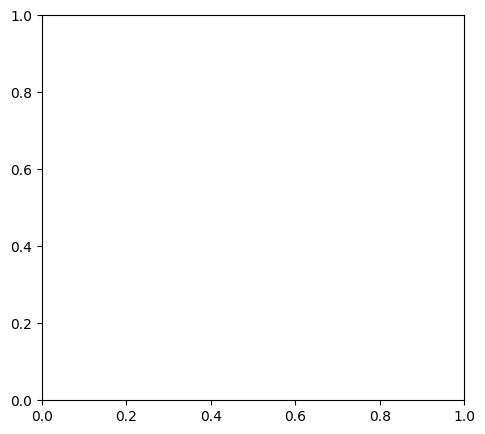

In [20]:
import torch.nn as nn
import torch.optim as optim  # <- add this import
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
weight_decay = 1e-6

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1)

# Train the model
train_accuracy_list, val_accuracy_list, train_cost_list, val_cost_list = train_model(
    model=model,
    n_epochs=50,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    scheduler=scheduler,
    optimizer=optimizer
)


Evaluating: 100%|██████████| 6/6 [00:00<00:00,  8.28it/s]


AUC-ROC: 0.9999
Accuracy: 0.9892
Precision: 0.9895
Recall: 0.9892
F1 Score: 0.9887


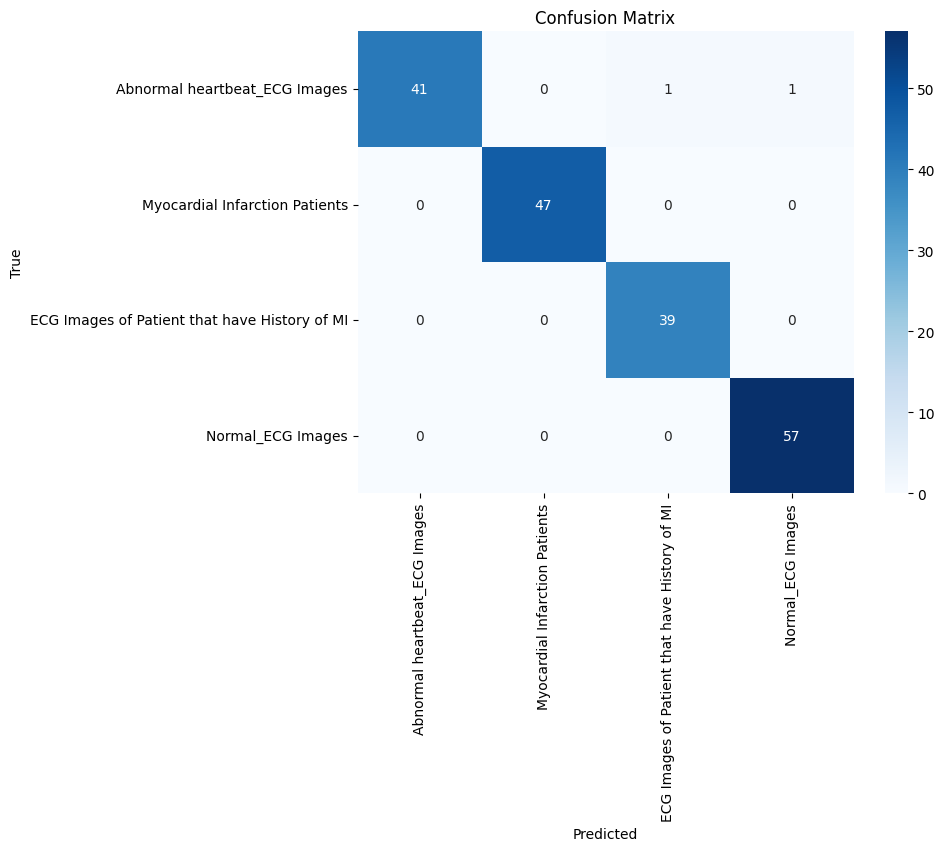

In [21]:
class_names = ['Abnormal heartbeat_ECG Images', 'Myocardial Infarction Patients' , 'ECG Images of Patient that have History of MI' , "Normal_ECG Images"]
evaluate_model(model, test_loader, class_names)

In [22]:
best_model = model
best_model.load_state_dict(torch.load('model_Custom_xception.pt', map_location=device))
best_model.to(device)
best_model.eval()


Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

In [23]:
#Test Function
from sklearn.metrics import classification_report


def test_model(model, test_loader, criterion, device='cuda'):
    model.eval()
    test_cost = 0.0
    test_correct = 0
    N_test = len(test_loader.dataset)
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss = criterion(outputs, labels)
            
            test_cost += test_loss.item()
            _, yhat = outputs.max(1)
            test_correct += (yhat == labels).sum().item()
    
    test_cost /= len(test_loader)
    test_acc = test_correct / N_test
    
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
    from sklearn.metrics import classification_report
import torch

# Define class names properly
classes = [
    "Abnormal heartbeat ECG Images",
    "Myocardial Infarction Patients",
    "ECG Images of Patient with History of MI",
    "Normal ECG Images"
]

# Move model to eval mode and device
best_model.eval()
best_model.to(device)

# Lists to store true labels and predictions
y_pred = []
y_true = []

# Iterate over test data
for x, y in torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32):
    x = x.to(device)
    y = y.to(device)

    with torch.no_grad():
        outputs = best_model(x)
        _, yhat = outputs.max(1)

        y_pred.extend(yhat.cpu().numpy())
        y_true.extend(y.cpu().numpy())

# Generate classification report
report = classification_report(y_true, y_pred, target_names=classes)
print(report)


                                          precision    recall  f1-score   support

           Abnormal heartbeat ECG Images       1.00      0.95      0.98        43
          Myocardial Infarction Patients       1.00      1.00      1.00        47
ECG Images of Patient with History of MI       0.97      1.00      0.99        39
                       Normal ECG Images       0.98      1.00      0.99        57

                                accuracy                           0.99       186
                               macro avg       0.99      0.99      0.99       186
                            weighted avg       0.99      0.99      0.99       186



In [24]:
best_model = model
best_model.load_state_dict(torch.load('model_Custom_xception.pt'))
test_model(best_model, test_loader, criterion)


Test Loss: 0.0184, Test Acc: 0.9892


**Efficientnetb7**

In [ ]:
import torch
import torch.nn as nn
from timm import create_model

class CustomEfficientNetB7(nn.Module):
    def __init__(self, num_classes):
        super(CustomEfficientNetB7, self).__init__()

        # Load pretrained EfficientNetB7 backbone
        self.backbone = create_model('efficientnet_b7', pretrained=True, num_classes=0)  # remove original head

        # Custom Depthwise MBConv-like Block
        self.custom_block = nn.Sequential(
            nn.Conv2d(2560, 4, kernel_size=1),             # 1x1 expansion (input_channels -> 4)
            nn.Conv2d(4, 4, kernel_size=3, padding=1, groups=4),  # depthwise conv
            nn.Conv2d(4, 256, kernel_size=1),              # 1x1 projection (4 -> 256)
            nn.ReLU(),
        )

        # Pooling layer for robustness
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling

        # Final classifier head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)          # Extract high-level features (B, 2560, 7, 7)
        x = self.custom_block(x)      # Custom MBConv-style block
        x = self.pool(x)              # AvgPool -> (B, 256, 1, 1)
        x = self.classifier(x)        # Flatten + FC
        return x

In [ ]:
# Training function with tqdm
def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, n_epochs=50, patience=10):
    import numpy as np
    import torch
    from tqdm import tqdm

    # ✅ Define device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    N_test = len(val_loader.dataset)
    N_train = len(train_loader.dataset)
    train_accuracy_list = []
    val_accuracy_list = []
    train_cost_list = []
    val_cost_list = []

    val_loss_min = np.Inf
    patience_counter = 0

    for epoch in range(n_epochs):
        model.train()
        train_cost = 0.0
        train_correct = 0

        for x_train, y_train in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{n_epochs}", unit="batch"):
            # ✅ Move data to device
            x_train, y_train = x_train.to(device), y_train.to(device)

            optimizer.zero_grad()
            outputs = model(x_train)
            train_loss = criterion(outputs, y_train)
            _, yhat = outputs.max(1)
            train_correct += (yhat == y_train).sum().item()
            train_loss.backward()
            optimizer.step()
            train_cost += train_loss.item()

        train_cost /= len(train_loader)
        train_cost_list.append(train_cost)

        train_accuracy = train_correct / N_train
        train_accuracy_list.append(train_accuracy)

        # Validation
        model.eval()
        val_cost = 0.0
        val_correct = 0

        with torch.no_grad():
            for x_test, y_test in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{n_epochs} [val]", unit="batch"):
                # ✅ Move data to device
                x_test, y_test = x_test.to(device), y_test.to(device)

                outputs_test = model(x_test)
                val_loss = criterion(outputs_test, y_test)
                _, yhat = outputs_test.max(1)
                val_correct += (yhat == y_test).sum().item()
                val_cost += val_loss.item()

        val_cost /= len(val_loader)
        val_cost_list.append(val_cost)

        val_accuracy = val_correct / N_test
        val_accuracy_list.append(val_accuracy)

        print(f"--> Epoch {epoch + 1} | Train Loss: {train_cost:.4f} | Val Loss: {val_cost:.4f} | Train Acc: {train_accuracy * 100:.2f}% | Val Acc: {val_accuracy * 100:.2f}%")

        # Step the scheduler
        scheduler.step(val_cost)

        if val_cost < val_loss_min:
            print(f'Validation loss decreased ({val_loss_min:.6f} → {val_cost:.6f}). Saving model ...')
            torch.save(model.state_dict(), 'model_Custom_efficientneetb7_180.pt')
            val_loss_min = val_cost
            patience_counter = 0
        else:
            patience_counter += 1
            print(f'No reduction in validation loss | Patience count: {patience_counter}')
            if patience_counter >= patience:
                print('Early stopping triggered.')
                break

    return train_accuracy_list, val_accuracy_list, train_cost_list, val_cost_list

In [ ]:
import torch.nn as nn
import torch.optim as optim  # <- add this import
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
weight_decay = 1e-6

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.1)

# Train the model
train_accuracy_list, val_accuracy_list, train_cost_list, val_cost_list = train_model(
    model=model,
    n_epochs=50,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    scheduler=scheduler,
    optimizer=optimizer
)

In [ ]:
class_names = ['Abnormal heartbeat_ECG Images', 'Myocardial Infarction Patients' , 'ECG Images of Patient that have History of MI' , "Normal_ECG Images"]
evaluate_model(model, test_loader, class_names)

In [ ]:
import matplotlib.pyplot as plt

# Train your model
train_acc, val_acc, train_loss, val_loss = train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, n_epochs=50, patience=10)

# Plot Loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
#Test Function

def test_model(model, test_loader, criterion, device='cuda'):
    model.eval()
    test_cost = 0.0
    test_correct = 0
    N_test = len(test_loader.dataset)
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss = criterion(outputs, labels)
            
            test_cost += test_loss.item()
            _, yhat = outputs.max(1)
            test_correct += (yhat == labels).sum().item()
    
    test_cost /= len(test_loader)
    test_acc = test_correct / N_test
    
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
    from sklearn.metrics import classification_report
import torch

# Define class names properly
classes = [
    "Abnormal heartbeat ECG Images",
    "Myocardial Infarction Patients",
    "ECG Images of Patient with History of MI",
    "Normal ECG Images"
]

# Move model to eval mode and device
best_model.eval()
best_model.to(device)

# Lists to store true labels and predictions
y_pred = []
y_true = []

# Iterate over test data
for x, y in torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32):
    x = x.to(device)
    y = y.to(device)

    with torch.no_grad():
        outputs = best_model(x)
        _, yhat = outputs.max(1)

        y_pred.extend(yhat.cpu().numpy())
        y_true.extend(y.cpu().numpy())

# Generate classification report
report = classification_report(y_true, y_pred, target_names=classes)
print(report)


**Densenet201**

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models import densenet201
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import numpy as np
from tqdm import tqdm

# Your dataset class here (MSIDDataset assumed)
# from your_dataset_file import MSIDDataset  
# X_train, y_train, X_val, y_val, X_test, y_test should be defined before

# -------------------------
# Model definition
# -------------------------
class ModifiedDenseNet201(nn.Module):
    def __init__(self, num_classes=4):
        super(ModifiedDenseNet201, self).__init__()
        backbone = densenet201(pretrained=True)
        self.features = backbone.features  # use full pretrained DenseNet201 features

        # Stronger classification head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(1920, 256),  # 1920 is DenseNet201 feature channels output
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x



In [32]:
model = ModifiedDenseNet201(num_classes=4).to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
# -------------------------
# Training function with AMP and early stopping
# -------------------------
def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, n_epochs=100, patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    scaler = GradScaler()

    train_accuracy_list, val_accuracy_list = [], []
    train_loss_list, val_loss_list = [], []

    best_val_loss = np.inf
    patience_counter = 0

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{n_epochs} - Train", leave=False)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_correct += (preds == labels).sum().item()
            total += images.size(0)

            loop.set_postfix(loss=loss.item())

        train_loss = running_loss / total
        train_acc = running_correct / total
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{n_epochs} - Val", leave=False):
                images, labels = images.to(device), labels.to(device)
                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += images.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_acc)

        print(f"Epoch {epoch + 1}/{n_epochs} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

        # Scheduler step (cosine annealing does not take metrics)
        scheduler.step()

        # Early stopping & checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "MODIFIED_DENSENET201.pt")
            print("Validation loss decreased - saving model.")
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epochs.")
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    return train_accuracy_list, val_accuracy_list, train_loss_list, val_loss_list



In [35]:
# -------------------------
# Training function with AMP and early stopping
# -------------------------
def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, n_epochs=100, patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    scaler = GradScaler()

    train_accuracy_list, val_accuracy_list = [], []
    train_loss_list, val_loss_list = [], []

    best_val_loss = np.inf
    patience_counter = 0

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{n_epochs} - Train", leave=False)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_correct += (preds == labels).sum().item()
            total += images.size(0)

            loop.set_postfix(loss=loss.item())

        train_loss = running_loss / total
        train_acc = running_correct / total
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{n_epochs} - Val", leave=False):
                images, labels = images.to(device), labels.to(device)
                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += images.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_acc)

        print(f"Epoch {epoch + 1}/{n_epochs} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

        # Scheduler step: handle both ReduceLROnPlateau and others
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)
        else:
            scheduler.step()

        # Early stopping & checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "MODIFIED_DENSENET201.pt")
            print("Validation loss decreased - saving model.")
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epochs.")
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    return train_accuracy_list, val_accuracy_list, train_loss_list, val_loss_list


In [36]:
import torch.nn as nn
import torch.optim as optim  # <- add this import
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
weight_decay = 1e-6

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1)

# Train the model
train_accuracy_list, val_accuracy_list, train_cost_list, val_cost_list = train_model(
    model=model,
    n_epochs=50,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    scheduler=scheduler,
    optimizer=optimizer
)


/tmp/ipykernel_36/3759884213.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/50 - Train:   0%|          | 0/21 [00:00<?, ?it/s]/tmp/ipykernel_36/3759884213.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/50 - Val:   0%|          | 0/3 [00:00<?, ?it/s]                        /tmp/ipykernel_36/3759884213.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/50 | Train Loss: 0.9777 | Train Acc: 62.71% | Val Loss: 0.7419 | Val Acc: 69.89%
Validation loss decreased - saving model.


Epoch 2/50 | Train Loss: 0.5528 | Train Acc: 81.36% | Val Loss: 0.3486 | Val Acc: 86.02%
Validation loss decreased - saving model.


Epoch 3/50 | Train Loss: 0.3607 | Train Acc: 87.52% | Val Loss: 0.4487 | Val Acc: 81.72%
No improvement in validation loss for 1 epochs.


Epoch 4/50 | Train Loss: 0.3045 | Train Acc: 90.76% | Val Loss: 0.4349 | Val Acc: 79.57%
No improvement in validation loss for 2 epochs.


Epoch 5/50 | Train Loss: 0.2045 | Train Acc: 93.37% | Val Loss: 0.0775 | Val Acc: 97.85%
Validation loss decreased - saving model.


Epoch 6/50 | Train Loss: 0.1806 | Train Acc: 94.14% | Val Loss: 0.0903 | Val Acc: 96.77%
No improvement in validation loss for 1 epochs.


Epoch 7/50 | Train Loss: 0.1708 | Train Acc: 95.22% | Val Loss: 0.0874 | Val Acc: 97.85%
No improvement in validation loss for 2 epochs.


Epoch 8/50 | Train Loss: 0.1899 | Train Acc: 94.14% | Val Loss: 0.1197 | Val Acc: 94.62%
No improvement in validation loss for 3 epochs.


Epoch 9/50 | Train Loss: 0.1508 | Train Acc: 95.99% | Val Loss: 0.1238 | Val Acc: 94.62%
No improvement in validation loss for 4 epochs.


Epoch 10/50 | Train Loss: 0.1163 | Train Acc: 95.84% | Val Loss: 0.0484 | Val Acc: 97.85%
Validation loss decreased - saving model.


Epoch 11/50 | Train Loss: 0.1364 | Train Acc: 95.99% | Val Loss: 0.0695 | Val Acc: 96.77%
No improvement in validation loss for 1 epochs.


Epoch 12/50 | Train Loss: 0.1041 | Train Acc: 96.30% | Val Loss: 0.1140 | Val Acc: 95.70%
No improvement in validation loss for 2 epochs.


Epoch 13/50 | Train Loss: 0.1071 | Train Acc: 96.61% | Val Loss: 0.0496 | Val Acc: 97.85%
No improvement in validation loss for 3 epochs.


Epoch 14/50 | Train Loss: 0.0828 | Train Acc: 98.31% | Val Loss: 0.0324 | Val Acc: 98.92%
Validation loss decreased - saving model.


Epoch 15/50 | Train Loss: 0.1070 | Train Acc: 96.46% | Val Loss: 0.0510 | Val Acc: 97.85%
No improvement in validation loss for 1 epochs.


Epoch 16/50 | Train Loss: 0.0602 | Train Acc: 98.61% | Val Loss: 0.0201 | Val Acc: 100.00%
Validation loss decreased - saving model.


Epoch 17/50 | Train Loss: 0.0623 | Train Acc: 97.69% | Val Loss: 0.0270 | Val Acc: 98.92%
No improvement in validation loss for 1 epochs.


Epoch 18/50 | Train Loss: 0.0664 | Train Acc: 98.15% | Val Loss: 0.0336 | Val Acc: 98.92%
No improvement in validation loss for 2 epochs.


Epoch 19/50 | Train Loss: 0.0515 | Train Acc: 98.77% | Val Loss: 0.0243 | Val Acc: 98.92%
No improvement in validation loss for 3 epochs.


Epoch 20/50 | Train Loss: 0.0286 | Train Acc: 99.23% | Val Loss: 0.0259 | Val Acc: 98.92%
No improvement in validation loss for 4 epochs.


Epoch 21/50 | Train Loss: 0.0289 | Train Acc: 99.08% | Val Loss: 0.0228 | Val Acc: 98.92%
No improvement in validation loss for 5 epochs.


Epoch 22/50 | Train Loss: 0.0564 | Train Acc: 98.31% | Val Loss: 0.0070 | Val Acc: 100.00%
Validation loss decreased - saving model.


Epoch 23/50 | Train Loss: 0.0889 | Train Acc: 96.92% | Val Loss: 0.0283 | Val Acc: 98.92%
No improvement in validation loss for 1 epochs.


Epoch 24/50 | Train Loss: 0.1021 | Train Acc: 96.30% | Val Loss: 0.0893 | Val Acc: 97.85%
No improvement in validation loss for 2 epochs.


Epoch 25/50 | Train Loss: 0.0794 | Train Acc: 97.23% | Val Loss: 0.0411 | Val Acc: 97.85%
No improvement in validation loss for 3 epochs.


Epoch 26/50 | Train Loss: 0.0442 | Train Acc: 98.61% | Val Loss: 0.0568 | Val Acc: 97.85%
No improvement in validation loss for 4 epochs.


Epoch 27/50 | Train Loss: 0.0390 | Train Acc: 99.23% | Val Loss: 0.0195 | Val Acc: 100.00%
No improvement in validation loss for 5 epochs.


Epoch 28/50 | Train Loss: 0.0783 | Train Acc: 97.07% | Val Loss: 0.0463 | Val Acc: 98.92%
No improvement in validation loss for 6 epochs.


Epoch 29/50 | Train Loss: 0.0642 | Train Acc: 98.00% | Val Loss: 0.0323 | Val Acc: 98.92%
No improvement in validation loss for 7 epochs.


Epoch 30/50 | Train Loss: 0.0304 | Train Acc: 99.54% | Val Loss: 0.0184 | Val Acc: 100.00%
No improvement in validation loss for 8 epochs.


Epoch 31/50 | Train Loss: 0.0374 | Train Acc: 98.77% | Val Loss: 0.0274 | Val Acc: 98.92%
No improvement in validation loss for 9 epochs.


Epoch 32/50 | Train Loss: 0.0286 | Train Acc: 99.23% | Val Loss: 0.0308 | Val Acc: 98.92%
No improvement in validation loss for 10 epochs.
Early stopping triggered.


/tmp/ipykernel_36/3759884213.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/50 - Train:   0%|          | 0/21 [00:00<?, ?it/s]/tmp/ipykernel_36/3759884213.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/50 - Val:   0%|          | 0/3 [00:00<?, ?it/s]                          /tmp/ipykernel_36/3759884213.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/50 | Train Loss: 0.0207 | Train Acc: 99.69% | Val Loss: 0.0333 | Val Acc: 97.85%
Validation loss decreased - saving model.


Epoch 2/50 | Train Loss: 0.0224 | Train Acc: 99.38% | Val Loss: 0.0306 | Val Acc: 98.92%
Validation loss decreased - saving model.


Epoch 3/50 | Train Loss: 0.0374 | Train Acc: 99.08% | Val Loss: 0.0322 | Val Acc: 98.92%
No improvement in validation loss for 1 epochs.


Epoch 4/50 | Train Loss: 0.0305 | Train Acc: 98.77% | Val Loss: 0.0281 | Val Acc: 98.92%
Validation loss decreased - saving model.


Epoch 5/50 | Train Loss: 0.0315 | Train Acc: 99.08% | Val Loss: 0.0281 | Val Acc: 98.92%
No improvement in validation loss for 1 epochs.


Epoch 6/50 | Train Loss: 0.0160 | Train Acc: 99.85% | Val Loss: 0.0267 | Val Acc: 98.92%
Validation loss decreased - saving model.


Epoch 7/50 | Train Loss: 0.0150 | Train Acc: 99.85% | Val Loss: 0.0201 | Val Acc: 100.00%
Validation loss decreased - saving model.


Epoch 8/50 | Train Loss: 0.0232 | Train Acc: 99.23% | Val Loss: 0.0257 | Val Acc: 98.92%
No improvement in validation loss for 1 epochs.


Epoch 9/50 | Train Loss: 0.0186 | Train Acc: 99.69% | Val Loss: 0.0167 | Val Acc: 100.00%
Validation loss decreased - saving model.


Epoch 10/50 | Train Loss: 0.0121 | Train Acc: 99.69% | Val Loss: 0.0150 | Val Acc: 100.00%
Validation loss decreased - saving model.


Epoch 11/50 | Train Loss: 0.0144 | Train Acc: 99.69% | Val Loss: 0.0213 | Val Acc: 100.00%
No improvement in validation loss for 1 epochs.


Epoch 12/50 | Train Loss: 0.0197 | Train Acc: 99.23% | Val Loss: 0.0193 | Val Acc: 100.00%
No improvement in validation loss for 2 epochs.


Epoch 13/50 | Train Loss: 0.0245 | Train Acc: 99.54% | Val Loss: 0.0245 | Val Acc: 100.00%
No improvement in validation loss for 3 epochs.


Epoch 14/50 | Train Loss: 0.0154 | Train Acc: 99.85% | Val Loss: 0.0181 | Val Acc: 100.00%
No improvement in validation loss for 4 epochs.


Epoch 15/50 | Train Loss: 0.0277 | Train Acc: 99.23% | Val Loss: 0.0194 | Val Acc: 100.00%
No improvement in validation loss for 5 epochs.


Epoch 16/50 | Train Loss: 0.0165 | Train Acc: 99.85% | Val Loss: 0.0213 | Val Acc: 98.92%
No improvement in validation loss for 6 epochs.


Epoch 17/50 | Train Loss: 0.0353 | Train Acc: 98.77% | Val Loss: 0.0237 | Val Acc: 98.92%
No improvement in validation loss for 7 epochs.


Epoch 18/50 | Train Loss: 0.0306 | Train Acc: 99.54% | Val Loss: 0.0252 | Val Acc: 100.00%
No improvement in validation loss for 8 epochs.


Epoch 19/50 | Train Loss: 0.0167 | Train Acc: 99.23% | Val Loss: 0.0257 | Val Acc: 98.92%
No improvement in validation loss for 9 epochs.


Epoch 20/50 | Train Loss: 0.0273 | Train Acc: 99.54% | Val Loss: 0.0213 | Val Acc: 100.00%
No improvement in validation loss for 10 epochs.
Early stopping triggered.


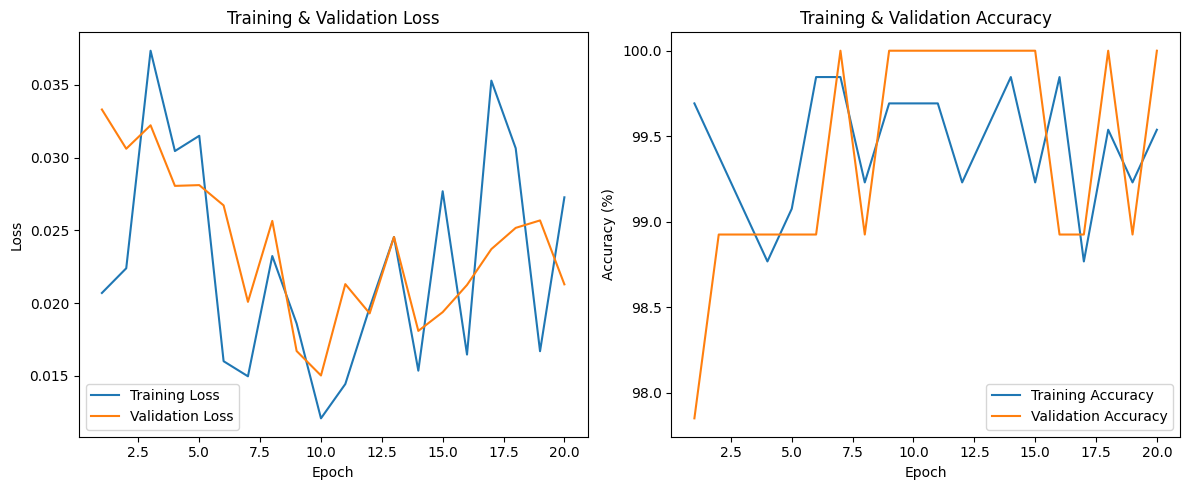

In [37]:
# === Train your model ===
train_accuracy_list, val_accuracy_list, train_cost_list, val_cost_list = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    n_epochs=50,
    patience=10
)

# === Plot losses and accuracies ===
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_cost_list) + 1), train_cost_list, label='Training Loss')
plt.plot(range(1, len(val_cost_list) + 1), val_cost_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy_list) + 1), [x * 100 for x in train_accuracy_list], label='Training Accuracy')
plt.plot(range(1, len(val_accuracy_list) + 1), [x * 100 for x in val_accuracy_list], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Evaluating: 100%|██████████| 6/6 [00:00<00:00,  7.40it/s]


AUC-ROC: 0.9998
Accuracy: 0.9839
Precision: 0.9844
Recall: 0.9839
F1 Score: 0.9835


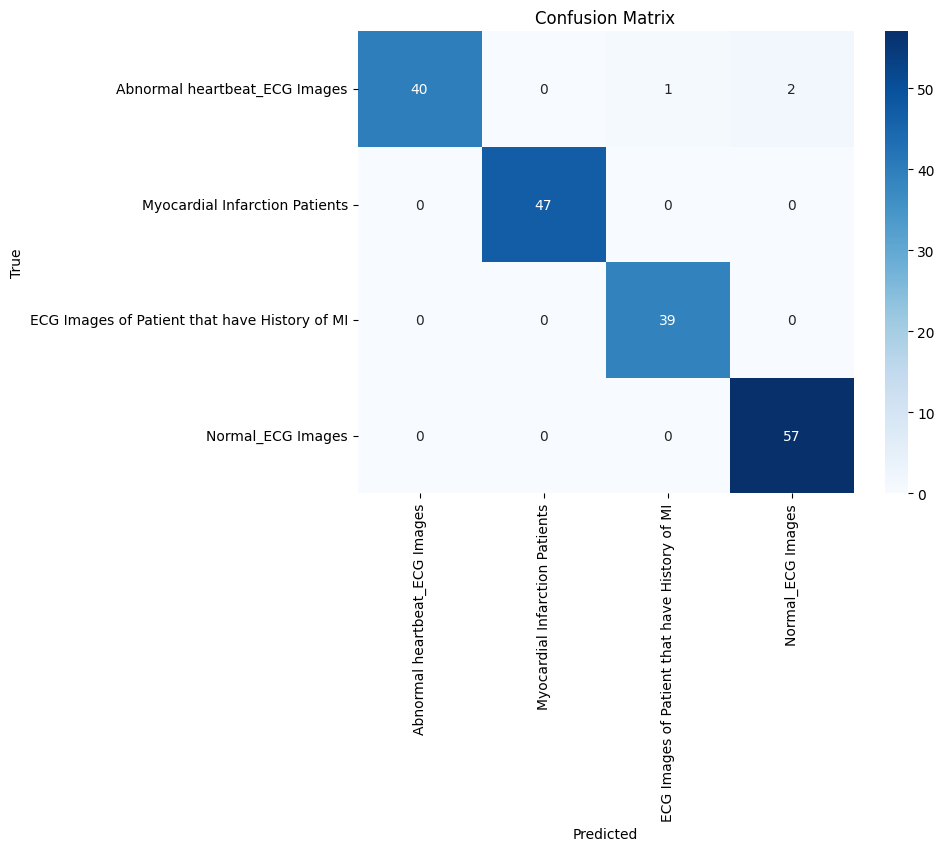

In [38]:
class_names = ['Abnormal heartbeat_ECG Images', 'Myocardial Infarction Patients' , 'ECG Images of Patient that have History of MI' , "Normal_ECG Images"]
evaluate_model(model, test_loader, class_names)

In [39]:
#Test Function

def test_model(model, test_loader, criterion, device='cuda'):
    model.eval()
    test_cost = 0.0
    test_correct = 0
    N_test = len(test_loader.dataset)
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss = criterion(outputs, labels)
            
            test_cost += test_loss.item()
            _, yhat = outputs.max(1)
            test_correct += (yhat == labels).sum().item()
    
    test_cost /= len(test_loader)
    test_acc = test_correct / N_test
    
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
    from sklearn.metrics import classification_report
import torch

# Define class names properly
classes = [
    "Abnormal heartbeat ECG Images",
    "Myocardial Infarction Patients",
    "ECG Images of Patient with History of MI",
    "Normal ECG Images"
]

# Move model to eval mode and device
best_model.eval()
best_model.to(device)

# Lists to store true labels and predictions
y_pred = []
y_true = []

# Iterate over test data
for x, y in torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32):
    x = x.to(device)
    y = y.to(device)

    with torch.no_grad():
        outputs = best_model(x)
        _, yhat = outputs.max(1)

        y_pred.extend(yhat.cpu().numpy())
        y_true.extend(y.cpu().numpy())

# Generate classification report
report = classification_report(y_true, y_pred, target_names=classes)
print(report)


                                          precision    recall  f1-score   support

           Abnormal heartbeat ECG Images       1.00      0.95      0.98        43
          Myocardial Infarction Patients       1.00      1.00      1.00        47
ECG Images of Patient with History of MI       0.97      1.00      0.99        39
                       Normal ECG Images       0.98      1.00      0.99        57

                                accuracy                           0.99       186
                               macro avg       0.99      0.99      0.99       186
                            weighted avg       0.99      0.99      0.99       186



In [41]:
#Test Function

def test_model(model, test_loader, criterion, device='cuda'):
    model.eval()
    test_cost = 0.0
    test_correct = 0
    N_test = len(test_loader.dataset)
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss = criterion(outputs, labels)
            
            test_cost += test_loss.item()
            _, yhat = outputs.max(1)
            test_correct += (yhat == labels).sum().item()
    
    test_cost /= len(test_loader)
    test_acc = test_correct / N_test
    
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')


In [42]:
best_model = model
best_model.load_state_dict(torch.load('MODIFIED_DENSENET201.pt'))
test_model(best_model, test_loader, criterion)


Test Loss: 0.0040, Test Acc: 0.9946


In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import numpy as np
from tqdm import tqdm

# -------------------------
# Training function
# -------------------------
def train_one_fold(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_acc = 100. * correct / total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_acc = 100. * val_correct / val_total
        print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}% | Val Acc={val_acc:.2f}%")

    return model

# -------------------------
# K-Fold Cross Validation
# -------------------------
def run_kfold(dataset, transform_train, transform_val_test,
              k=5, num_classes=4, batch_size=32, epochs=10, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)

    results = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"\n========== Fold {fold+1} ==========")

        # Create subsets
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Assign transforms dynamically
        train_subset.dataset.transform = transform_train
        val_subset.dataset.transform = transform_val_test

        # Loaders
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)

        # Fresh model, loss, optimizer
        model = ModifiedDenseNet201(num_classes=num_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Train fold
        trained_model = train_one_fold(model, train_loader, val_loader, criterion, optimizer, device, epochs)

        # Final validation eval
        trained_model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = trained_model(inputs)
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_acc = 100. * val_correct / val_total
        results.append(val_acc)
        print(f"Fold {fold+1} Final Val Acc: {val_acc:.2f}%")

    print("\nK-Fold Results:", results)
    print("Average Accuracy:", np.mean(results))


In [68]:
# =========================================================
# 1. Imports
# =========================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from sklearn.model_selection import KFold
from PIL import Image
from tqdm import tqdm

# =========================================================
class ECGDataset(Dataset):
    def __init__(self, X_paths, y, transform=None):
        assert len(X_paths) == len(y), f"X has {len(X_paths)} samples but y has {len(y)}"
        self.X_paths = X_paths  # list of image file paths
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X_paths)

    def __getitem__(self, idx):
        img_path = self.X_paths[idx]
        image = Image.open(img_path).convert('RGB')  # open as PIL image
        label = self.y[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


# =========================================================
# 3. Model: Modified DenseNet201
# =========================================================
class ModifiedDenseNet201(nn.Module):
    def __init__(self, num_classes=4):
        super(ModifiedDenseNet201, self).__init__()
        backbone = models.densenet201(pretrained=True)
        self.features = backbone.features
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(1920, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

# =========================================================
# 4. Training function for one fold
# =========================================================
def train_one_fold(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    model.to(device)
    best_val_acc = 0.0

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss, correct, total = 0, 0, 0
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)

        train_acc = correct / total
        train_loss /= total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_correct += predicted.eq(targets).sum().item()
                val_total += targets.size(0)

        val_acc = val_correct / val_total
        val_loss /= val_total

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f} Train Acc={train_acc:.4f} | "
              f"Val Loss={val_loss:.4f} Val Acc={val_acc:.4f}")

        # Save best model for this fold
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'best_model_fold.pth')

    return best_val_acc

# =========================================================
# 5. K-Fold Cross Validation
# =========================================================
def run_kfold_cross_validation(X, y, ModelClass, transform_train, transform_val,
                               k=5, epochs=10, batch_size=8, lr=1e-4, num_classes=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    fold_accuracies = []

    kfold = KFold(n_splits=k, shuffle=True, random_state=42)

    for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X)):
        print(f"\n========== Fold {fold_idx+1} ==========")

        train_subset = Subset(
            ECGDataset([X[i] for i in train_idx], [y[i] for i in train_idx], transform=transform_train),
            range(len(train_idx))
        )
        val_subset = Subset(
            ECGDataset([X[i] for i in val_idx], [y[i] for i in val_idx], transform=transform_val),
            range(len(val_idx))
        )

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)

        model = ModelClass(num_classes=num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        best_val_acc = train_one_fold(model, train_loader, val_loader, criterion, optimizer, device, epochs)
        fold_accuracies.append(best_val_acc)
        print(f"Fold {fold_idx+1} Best Val Accuracy: {best_val_acc:.4f}")

    print("\n========== K-Fold Results ==========")
    for i, acc in enumerate(fold_accuracies):
        print(f"Fold {i+1}: {acc:.4f}")
    print(f"Average Accuracy: {sum(fold_accuracies)/len(fold_accuracies):.4f}")

# =========================================================
# 6. Example transforms
# =========================================================
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# =========================================================
# 7. Load ECG image paths and labels
# =========================================================
import os
def load_ecg_data(data_dir):
    classes = sorted(os.listdir(data_dir))  # assumes each class is a subfolder
    image_paths = []
    labels = []
    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        for img_name in os.listdir(class_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_dir, img_name))
                labels.append(idx)
    return image_paths, labels, classes

data_dir = '/kaggle/input/d/proggaparmita/ecg-image-dataset/ECG Image dataset for Myocardial Infarction Compli/Jay_Prakash_Maurya'
X_list, y_list, classes = load_ecg_data(data_dir)

# =========================================================
# 8. Run K-Fold Cross-Validation
# =========================================================
run_kfold_cross_validation(
    X=X_list,
    y=y_list,
    ModelClass=ModifiedDenseNet201,
    transform_train=transform_train,
    transform_val=transform_val,
    k=5,
    epochs=10,
    batch_size=8,
    lr=1e-4,
    num_classes=len(classes)
)



========== Fold 1 ==========


Epoch 1 [Train]: 100%|██████████| 93/93 [00:20<00:00,  4.59it/s]


Epoch 1: Train Loss=1.0409 Train Acc=0.5755 | Val Loss=0.5342 Val Acc=0.8656


Epoch 2 [Train]: 100%|██████████| 93/93 [00:19<00:00,  4.71it/s]


Epoch 2: Train Loss=0.5157 Train Acc=0.8167 | Val Loss=0.3167 Val Acc=0.9140


Epoch 3 [Train]: 100%|██████████| 93/93 [00:20<00:00,  4.64it/s]


Epoch 3: Train Loss=0.4444 Train Acc=0.8369 | Val Loss=0.1667 Val Acc=0.9462


Epoch 4 [Train]: 100%|██████████| 93/93 [00:20<00:00,  4.60it/s]


Epoch 4: Train Loss=0.2982 Train Acc=0.9003 | Val Loss=0.1718 Val Acc=0.9355


Epoch 5 [Train]: 100%|██████████| 93/93 [00:20<00:00,  4.58it/s]


Epoch 5: Train Loss=0.2587 Train Acc=0.9097 | Val Loss=0.1327 Val Acc=0.9516


Epoch 6 [Train]: 100%|██████████| 93/93 [00:19<00:00,  4.67it/s]


Epoch 6: Train Loss=0.2531 Train Acc=0.9124 | Val Loss=0.1069 Val Acc=0.9785


Epoch 7 [Train]: 100%|██████████| 93/93 [00:19<00:00,  4.67it/s]


Epoch 7: Train Loss=0.1890 Train Acc=0.9434 | Val Loss=0.2939 Val Acc=0.9032


Epoch 8 [Train]: 100%|██████████| 93/93 [00:20<00:00,  4.58it/s]


Epoch 8: Train Loss=0.2153 Train Acc=0.9299 | Val Loss=0.1433 Val Acc=0.9624


Epoch 9 [Train]: 100%|██████████| 93/93 [00:20<00:00,  4.62it/s]


Epoch 9: Train Loss=0.1573 Train Acc=0.9488 | Val Loss=0.1540 Val Acc=0.9624


Epoch 10 [Train]: 100%|██████████| 93/93 [00:20<00:00,  4.57it/s]


Epoch 10: Train Loss=0.1828 Train Acc=0.9434 | Val Loss=0.0823 Val Acc=0.9570
Fold 1 Best Val Accuracy: 0.9785

========== Fold 2 ==========


Epoch 1 [Train]: 100%|██████████| 93/93 [00:20<00:00,  4.45it/s]


Epoch 1: Train Loss=1.0448 Train Acc=0.5849 | Val Loss=0.7078 Val Acc=0.7366


Epoch 2 [Train]: 100%|██████████| 93/93 [00:20<00:00,  4.45it/s]


Epoch 2: Train Loss=0.5467 Train Acc=0.8046 | Val Loss=0.2711 Val Acc=0.9409


Epoch 3 [Train]: 100%|██████████| 93/93 [00:20<00:00,  4.56it/s]


Epoch 3: Train Loss=0.3889 Train Acc=0.8558 | Val Loss=0.2436 Val Acc=0.9355


Epoch 4 [Train]: 100%|██████████| 93/93 [00:20<00:00,  4.58it/s]


Epoch 4: Train Loss=0.3103 Train Acc=0.8922 | Val Loss=0.2714 Val Acc=0.9032


Epoch 5 [Train]: 100%|██████████| 93/93 [00:20<00:00,  4.57it/s]


Epoch 5: Train Loss=0.3032 Train Acc=0.8868 | Val Loss=0.2260 Val Acc=0.9301


Epoch 6 [Train]: 100%|██████████| 93/93 [00:20<00:00,  4.54it/s]


Epoch 6: Train Loss=0.1984 Train Acc=0.9326 | Val Loss=0.2243 Val Acc=0.9409


Epoch 7 [Train]: 100%|██████████| 93/93 [00:20<00:00,  4.57it/s]


Epoch 7: Train Loss=0.2364 Train Acc=0.9299 | Val Loss=0.1414 Val Acc=0.9570


Epoch 8 [Train]: 100%|██████████| 93/93 [00:20<00:00,  4.56it/s]


Epoch 8: Train Loss=0.1870 Train Acc=0.9299 | Val Loss=0.1460 Val Acc=0.9516


Epoch 9 [Train]: 100%|██████████| 93/93 [00:20<00:00,  4.49it/s]


Epoch 9: Train Loss=0.1900 Train Acc=0.9313 | Val Loss=0.1002 Val Acc=0.9731


Epoch 10 [Train]: 100%|██████████| 93/93 [00:20<00:00,  4.54it/s]


Epoch 10: Train Loss=0.1032 Train Acc=0.9677 | Val Loss=0.1171 Val Acc=0.9677
Fold 2 Best Val Accuracy: 0.9731

========== Fold 3 ==========


Epoch 1 [Train]: 100%|██████████| 93/93 [00:19<00:00,  4.70it/s]


Epoch 1: Train Loss=1.0285 Train Acc=0.5809 | Val Loss=0.6099 Val Acc=0.7366


Epoch 2 [Train]: 100%|██████████| 93/93 [00:20<00:00,  4.64it/s]


Epoch 2: Train Loss=0.5670 Train Acc=0.7911 | Val Loss=0.2707 Val Acc=0.9194


Epoch 3 [Train]: 100%|██████████| 93/93 [00:20<00:00,  4.63it/s]


Epoch 3: Train Loss=0.3689 Train Acc=0.8854 | Val Loss=0.3007 Val Acc=0.9086


Epoch 4 [Train]: 100%|██████████| 93/93 [00:19<00:00,  4.66it/s]


Epoch 4: Train Loss=0.2664 Train Acc=0.9137 | Val Loss=0.1713 Val Acc=0.9624


Epoch 5 [Train]: 100%|██████████| 93/93 [00:20<00:00,  4.64it/s]


Epoch 5: Train Loss=0.2878 Train Acc=0.9084 | Val Loss=0.1919 Val Acc=0.9247


Epoch 6 [Train]: 100%|██████████| 93/93 [00:20<00:00,  4.64it/s]


Epoch 6: Train Loss=0.2382 Train Acc=0.9191 | Val Loss=0.1673 Val Acc=0.9624


Epoch 7 [Train]: 100%|██████████| 93/93 [00:19<00:00,  4.69it/s]


Epoch 7: Train Loss=0.2286 Train Acc=0.9326 | Val Loss=0.1729 Val Acc=0.9462


Epoch 8 [Train]: 100%|██████████| 93/93 [00:20<00:00,  4.62it/s]


Epoch 8: Train Loss=0.1877 Train Acc=0.9420 | Val Loss=0.1202 Val Acc=0.9462


Epoch 9 [Train]: 100%|██████████| 93/93 [00:20<00:00,  4.56it/s]


Epoch 9: Train Loss=0.1247 Train Acc=0.9609 | Val Loss=0.1556 Val Acc=0.9570


Epoch 10 [Train]: 100%|██████████| 93/93 [00:20<00:00,  4.62it/s]


Epoch 10: Train Loss=0.1775 Train Acc=0.9286 | Val Loss=0.1256 Val Acc=0.9516
Fold 3 Best Val Accuracy: 0.9624

========== Fold 4 ==========


Epoch 1 [Train]: 100%|██████████| 93/93 [00:20<00:00,  4.59it/s]


Epoch 1: Train Loss=1.0346 Train Acc=0.5747 | Val Loss=0.6004 Val Acc=0.8541


Epoch 2 [Train]: 100%|██████████| 93/93 [00:19<00:00,  4.66it/s]


Epoch 2: Train Loss=0.5404 Train Acc=0.8102 | Val Loss=0.2755 Val Acc=0.9351


Epoch 3 [Train]: 100%|██████████| 93/93 [00:19<00:00,  4.73it/s]


Epoch 3: Train Loss=0.4404 Train Acc=0.8439 | Val Loss=0.1305 Val Acc=0.9838


Epoch 4 [Train]: 100%|██████████| 93/93 [00:19<00:00,  4.71it/s]


Epoch 4: Train Loss=0.3353 Train Acc=0.8843 | Val Loss=0.1100 Val Acc=0.9784


Epoch 5 [Train]: 100%|██████████| 93/93 [00:19<00:00,  4.70it/s]


Epoch 5: Train Loss=0.3116 Train Acc=0.8964 | Val Loss=0.1934 Val Acc=0.9297


Epoch 6 [Train]: 100%|██████████| 93/93 [00:19<00:00,  4.74it/s]


Epoch 6: Train Loss=0.2827 Train Acc=0.9058 | Val Loss=0.0814 Val Acc=0.9730


Epoch 7 [Train]: 100%|██████████| 93/93 [00:19<00:00,  4.65it/s]


Epoch 7: Train Loss=0.1650 Train Acc=0.9462 | Val Loss=0.0844 Val Acc=0.9730


Epoch 8 [Train]: 100%|██████████| 93/93 [00:19<00:00,  4.85it/s]


Epoch 8: Train Loss=0.1943 Train Acc=0.9394 | Val Loss=0.1790 Val Acc=0.9297


Epoch 9 [Train]: 100%|██████████| 93/93 [00:19<00:00,  4.69it/s]


Epoch 9: Train Loss=0.1780 Train Acc=0.9381 | Val Loss=0.0860 Val Acc=0.9622


Epoch 10 [Train]: 100%|██████████| 93/93 [00:19<00:00,  4.79it/s]


Epoch 10: Train Loss=0.1540 Train Acc=0.9542 | Val Loss=0.0549 Val Acc=0.9730
Fold 4 Best Val Accuracy: 0.9838

========== Fold 5 ==========


Epoch 1 [Train]: 100%|██████████| 93/93 [00:19<00:00,  4.71it/s]


Epoch 1: Train Loss=1.0577 Train Acc=0.5505 | Val Loss=0.7793 Val Acc=0.7459


Epoch 2 [Train]: 100%|██████████| 93/93 [00:20<00:00,  4.62it/s]


Epoch 2: Train Loss=0.5823 Train Acc=0.8048 | Val Loss=0.1805 Val Acc=0.9622


Epoch 3 [Train]: 100%|██████████| 93/93 [00:19<00:00,  4.65it/s]


Epoch 3: Train Loss=0.4214 Train Acc=0.8546 | Val Loss=0.2061 Val Acc=0.9189


Epoch 4 [Train]: 100%|██████████| 93/93 [00:19<00:00,  4.72it/s]


Epoch 4: Train Loss=0.3781 Train Acc=0.8748 | Val Loss=0.0719 Val Acc=0.9730


Epoch 5 [Train]: 100%|██████████| 93/93 [00:20<00:00,  4.64it/s]


Epoch 5: Train Loss=0.2810 Train Acc=0.9098 | Val Loss=0.1262 Val Acc=0.9730


Epoch 6 [Train]: 100%|██████████| 93/93 [00:19<00:00,  4.67it/s]


Epoch 6: Train Loss=0.3127 Train Acc=0.8923 | Val Loss=0.1998 Val Acc=0.9568


Epoch 7 [Train]: 100%|██████████| 93/93 [00:20<00:00,  4.64it/s]


Epoch 7: Train Loss=0.2251 Train Acc=0.9206 | Val Loss=0.1262 Val Acc=0.9568


Epoch 8 [Train]: 100%|██████████| 93/93 [00:20<00:00,  4.63it/s]


Epoch 8: Train Loss=0.1782 Train Acc=0.9367 | Val Loss=0.0665 Val Acc=0.9838


Epoch 9 [Train]: 100%|██████████| 93/93 [00:20<00:00,  4.59it/s]


Epoch 9: Train Loss=0.1766 Train Acc=0.9381 | Val Loss=0.0845 Val Acc=0.9622


Epoch 10 [Train]: 100%|██████████| 93/93 [00:20<00:00,  4.60it/s]


Epoch 10: Train Loss=0.1371 Train Acc=0.9556 | Val Loss=0.0732 Val Acc=0.9838
Fold 5 Best Val Accuracy: 0.9838

========== K-Fold Results ==========
Fold 1: 0.9785
Fold 2: 0.9731
Fold 3: 0.9624
Fold 4: 0.9838
Fold 5: 0.9838
Average Accuracy: 0.9763


In [100]:
import os
from tqdm import tqdm
import cv2
import numpy as np
from PIL import Image
import torch

# Mapping class indices to colors (RGB)
class_colors = {
    0: (0, 0, 255),       # Blue
    1: (0, 255, 0),       # Green
    2: (255, 0, 0),       # Red
    3: (255, 255, 0),     # Yellow
}

# Base directory containing class subfolders
base_dir = '/kaggle/input/d/proggaparmita/ecg-image-dataset/ECG Image dataset for Myocardial Infarction Compli/Jay_Prakash_Maurya'

# Output directory for Grad-CAM images
output_dir = '/kaggle/working/gradcam_outputs'
os.makedirs(output_dir, exist_ok=True)

model.eval()  # make sure model is in eval mode

for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    class_output_dir = os.path.join(output_dir, class_name.replace(" ", "_"))
    os.makedirs(class_output_dir, exist_ok=True)

    for img_file in tqdm(os.listdir(class_path), desc=f"Processing {class_name}"):
        if not img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        img_path = os.path.join(class_path, img_file)
        image = Image.open(img_path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0).to(device)

        # Forward pass to get prediction
        with torch.no_grad():
            outputs = model(input_tensor)
            pred_class = outputs.argmax(dim=1).item()

        # Generate Grad-CAM
        cam = grad_cam(input_tensor, class_idx=pred_class)
        cam_resized = np.uint8(cam * 255)
        cam_resized = cv2.resize(cam_resized, (224,224))
        cam_resized = np.stack([cam_resized]*3, axis=2)

        # Overlay heatmap with class-specific color
        heatmap = cv2.applyColorMap(cam_resized, cv2.COLORMAP_JET)
        color = class_colors.get(pred_class, (255,255,255))
        overlay = cv2.addWeighted(np.array(image.resize((224,224))), 0.6, heatmap, 0.4, 0)
        # Optional: tint overlay with class color
        overlay = cv2.addWeighted(overlay, 0.7, np.full_like(overlay, color), 0.3, 0)

        # Save overlay image
        out_path = os.path.join(class_output_dir, f"pred{pred_class}_gradcam_{img_file}")
        cv2.imwrite(out_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))


Processing Myocardial Infarction Patients: 100%|██████████| 239/239 [00:59<00:00,  4.04it/s]
Processing ECG Images of Patient that have History of MI: 100%|██████████| 172/172 [00:42<00:00,  4.01it/s]
Processing Normal_ECG Images: 100%|██████████| 284/284 [01:09<00:00,  4.07it/s]


In [102]:
import matplotlib.pyplot as plt

def show_gradcam_grid(model, grad_cam, image_paths, transform, device, n_rows=2, n_cols=5):
    model.eval()
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    axes = axes.flatten()

    for i, img_path in enumerate(image_paths[:n_rows*n_cols]):
        image = Image.open(img_path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0).to(device)

        # Forward pass to get prediction
        with torch.no_grad():
            output = model(input_tensor)
            pred_class = output.argmax(dim=1).item()

        # Generate Grad-CAM
        cam = grad_cam(input_tensor, class_idx=pred_class)
        cam_resized = np.uint8(cam * 255)
        cam_resized = cv2.resize(cam_resized, (224,224))
        cam_resized = np.stack([cam_resized]*3, axis=2)
        heatmap = cv2.applyColorMap(cam_resized, cv2.COLORMAP_JET)
        overlay = cv2.addWeighted(np.array(image.resize((224,224))), 0.6, heatmap, 0.4, 0)

        axes[i].imshow(overlay)
        axes[i].set_title(f"Pred: {classes[pred_class]}")
        axes[i].axis("off")
    
    plt.tight_layout()
    plt.show()


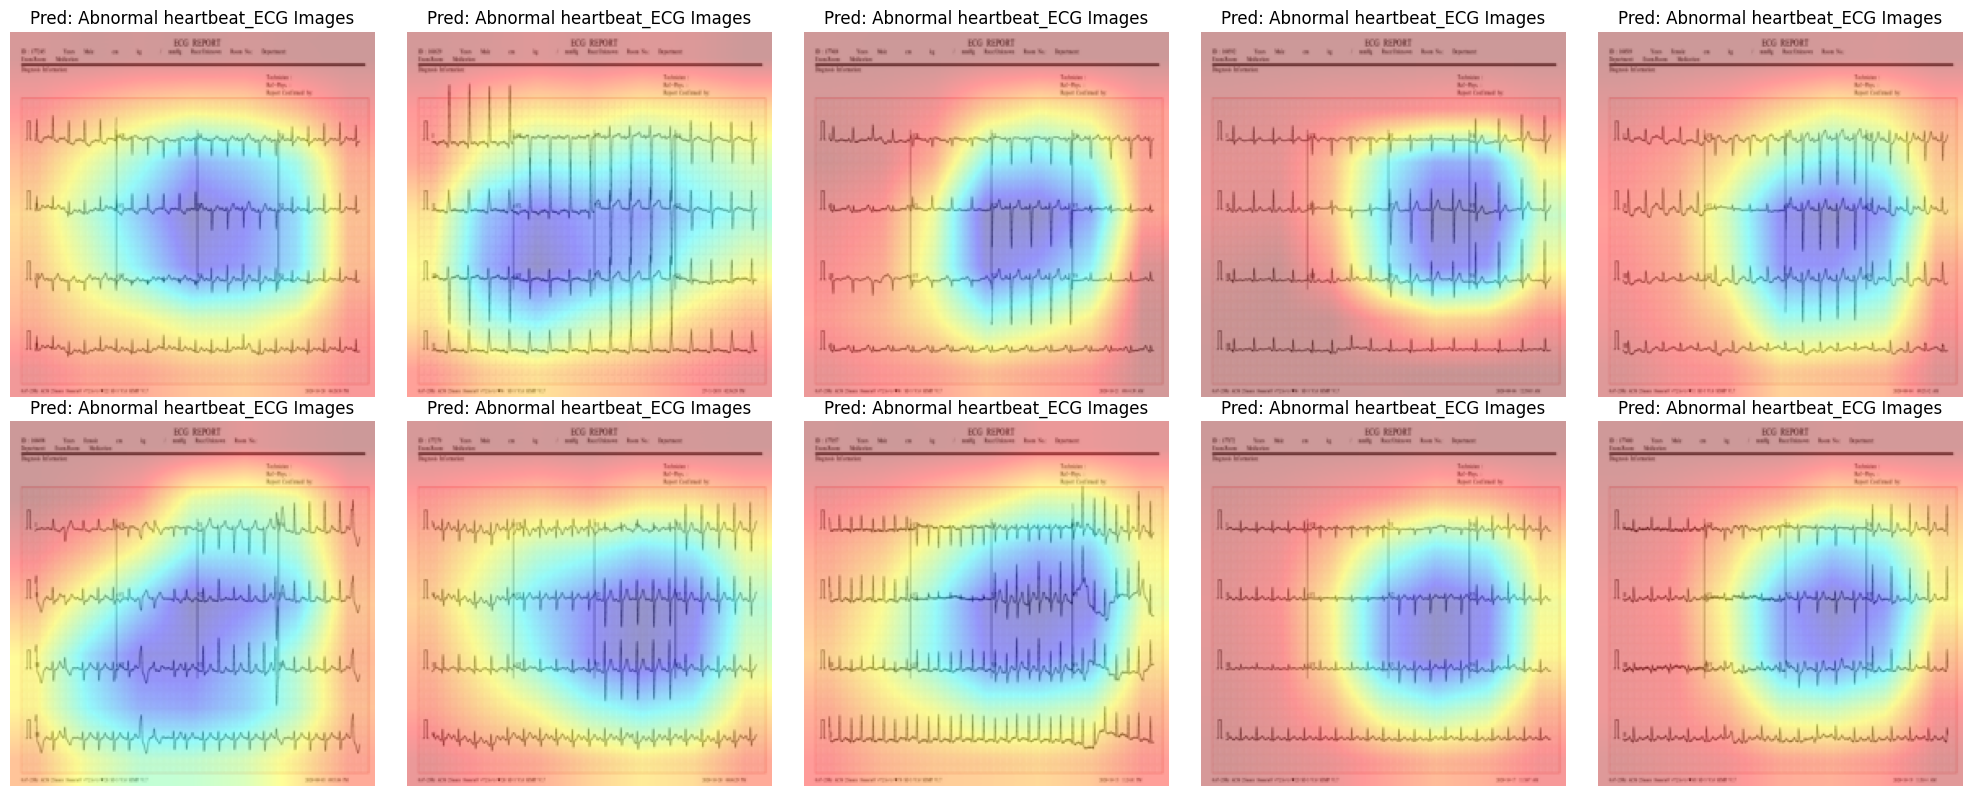

In [103]:
# pick 10 images from each class (or validation set)
sample_images = X_list[:10]  # replace X_list with your list of file paths
show_gradcam_grid(ecg_mff_model, grad_cam, sample_images, transform_val, device)


                                               precision    recall  f1-score   support

                Abnormal heartbeat_ECG Images       1.00      0.96      0.98        23
ECG Images of Patient that have History of MI       0.95      1.00      0.98        21
               Myocardial Infarction Patients       1.00      1.00      1.00        18
                            Normal_ECG Images       1.00      1.00      1.00        31

                                     accuracy                           0.99        93
                                    macro avg       0.99      0.99      0.99        93
                                 weighted avg       0.99      0.99      0.99        93



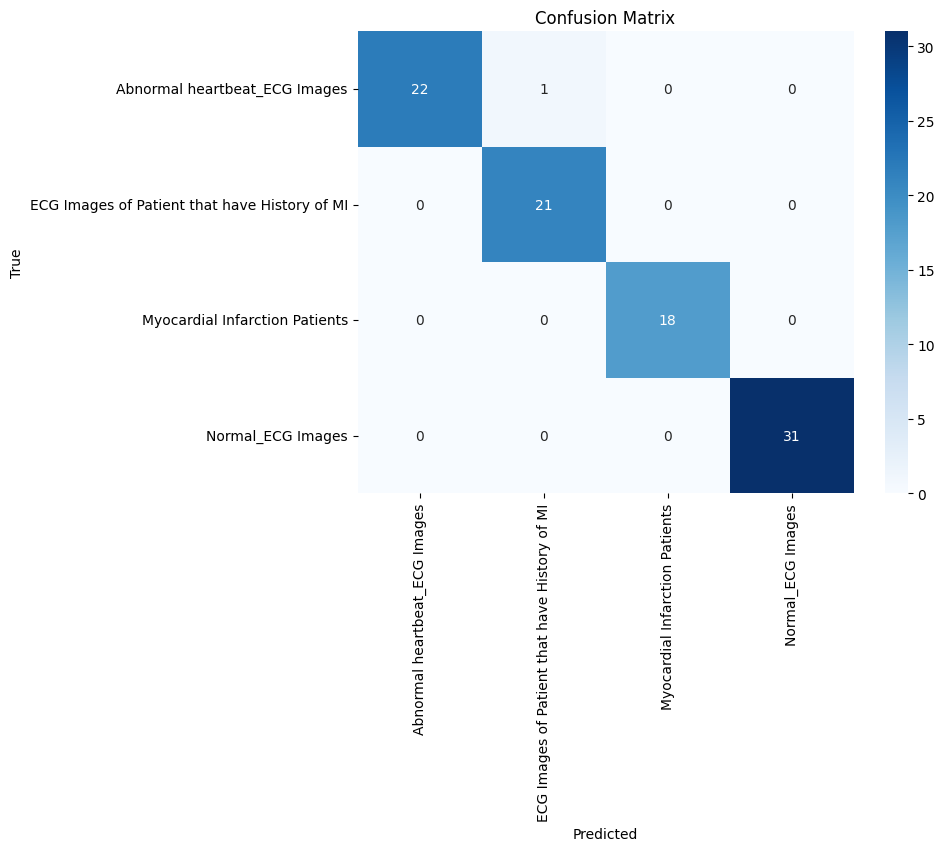

In [104]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:  # or test_loader
        images, labels = images.to(device), labels.to(device)
        outputs = ecg_mff_model(images)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds, target_names=classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [125]:
# === 1. Device ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# === 2. Dataset paths & classes ===
data_root = "/kaggle/input/d/proggaparmita/ecg-image-dataset/ECG Image dataset for Myocardial Infarction Compli"
base_path = os.path.join(data_root, "/kaggle/input/d/proggaparmita/ecg-image-dataset/ECG Image dataset for Myocardial Infarction Compli/Jay_Prakash_Maurya")
classes = sorted([c for c in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, c))])

In [130]:
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

In [131]:
# === 4. Dataset & DataLoader (example for train and val) ===
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_dataset = ImageFolder(base_path, transform=train_transforms)
val_dataset = ImageFolder(base_path, transform=val_transforms)  # ideally separate val path

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [132]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models import densenet201
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import numpy as np
from tqdm import tqdm

# Your dataset class here (MSIDDataset assumed)
# from your_dataset_file import MSIDDataset  
# X_train, y_train, X_val, y_val, X_test, y_test should be defined before

# -------------------------
# Model definition
# -------------------------
class ModifiedDenseNet201(nn.Module):
    def __init__(self, num_classes=4):
        super(ModifiedDenseNet201, self).__init__()
        backbone = densenet201(pretrained=True)
        self.features = backbone.features  # use full pretrained DenseNet201 features

        # Stronger classification head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(1920, 256),  # 1920 is DenseNet201 feature channels output
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x



In [133]:
model = ModifiedDenseNet201().to(device)


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 15.89 GiB of which 11.12 MiB is free. Process 3171 has 15.88 GiB memory in use. Of the allocated memory 13.40 GiB is allocated by PyTorch, and 2.18 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [80]:
import torch
import numpy as np
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion,
                n_epochs=100, patience=10, checkpoint_path="Fusion1.pt"):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    scaler = GradScaler()

    train_acc_list, val_acc_list = [], []
    train_loss_list, val_loss_list = [], []

    best_val_loss = np.inf
    patience_counter = 0

    for epoch in range(n_epochs):
        model.train()
        running_loss, running_correct, total = 0.0, 0, 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Train]", leave=False)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()

            # Only step if at least one gradient exists
            if any(p.grad is not None for p in model.parameters()):
                scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            running_correct += (preds == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=loss.item())

        train_loss = running_loss / total
        train_acc = running_correct / total
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Val]", leave=False):
                images, labels = images.to(device), labels.to(device)
                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                preds = outputs.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

        print(f"Epoch {epoch+1}/{n_epochs} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

        # Scheduler step
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)
        else:
            scheduler.step()

        # Early stopping & checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Validation loss decreased - saving model to {checkpoint_path}")
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epochs.")
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    return train_acc_list, val_acc_list, train_loss_list, val_loss_list


In [83]:
# ==============================
# 1. Initialize your model
# ==============================
num_classes = len(classes)  # set this to the number of ECG classes
ecg_mff_model = ECG_MFF_Model(num_classes=num_classes)

# ==============================
# 2. Define optimizer, criterion, scheduler
# ==============================
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ecg_mff_model.parameters(), lr=1e-4)

# Optional: you can use ReduceLROnPlateau or StepLR
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
# or: scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# ==============================
# 3. Train the model
# ==============================
train_acc, val_acc, train_loss, val_loss = train_model(
    model=ecg_mff_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    n_epochs=50,
    patience=10,
    checkpoint_path="ECG_MFF_best.pt"
)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_36/506719483.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]/tmp/ipykernel_36/506719483.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/50 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]                        /tmp/ipykernel_36/506719483.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/50 | Train Loss: 1.2517 | Train Acc: 44.68% | Val Loss: 1.2183 | Val Acc: 53.76%
Validation loss decreased - saving model to ECG_MFF_best.pt


Epoch 2/50 | Train Loss: 0.8826 | Train Acc: 68.26% | Val Loss: 0.7261 | Val Acc: 81.72%
Validation loss decreased - saving model to ECG_MFF_best.pt


Epoch 3/50 | Train Loss: 0.6427 | Train Acc: 80.12% | Val Loss: 0.3751 | Val Acc: 92.47%
Validation loss decreased - saving model to ECG_MFF_best.pt


Epoch 4/50 | Train Loss: 0.4781 | Train Acc: 87.67% | Val Loss: 0.2851 | Val Acc: 95.70%
Validation loss decreased - saving model to ECG_MFF_best.pt


Epoch 5/50 | Train Loss: 0.3977 | Train Acc: 90.14% | Val Loss: 0.2380 | Val Acc: 97.85%
Validation loss decreased - saving model to ECG_MFF_best.pt


Epoch 6/50 | Train Loss: 0.3195 | Train Acc: 92.14% | Val Loss: 0.2105 | Val Acc: 96.77%
Validation loss decreased - saving model to ECG_MFF_best.pt


Epoch 7/50 | Train Loss: 0.2904 | Train Acc: 94.45% | Val Loss: 0.1904 | Val Acc: 96.77%
Validation loss decreased - saving model to ECG_MFF_best.pt


Epoch 8/50 | Train Loss: 0.2656 | Train Acc: 93.68% | Val Loss: 0.1932 | Val Acc: 97.85%
No improvement in validation loss for 1 epochs.


Epoch 9/50 | Train Loss: 0.2318 | Train Acc: 95.22% | Val Loss: 0.1195 | Val Acc: 98.92%
Validation loss decreased - saving model to ECG_MFF_best.pt


Epoch 10/50 | Train Loss: 0.2106 | Train Acc: 95.22% | Val Loss: 0.1003 | Val Acc: 98.92%
Validation loss decreased - saving model to ECG_MFF_best.pt


Epoch 11/50 | Train Loss: 0.1663 | Train Acc: 96.61% | Val Loss: 0.1528 | Val Acc: 97.85%
No improvement in validation loss for 1 epochs.


Epoch 12/50 | Train Loss: 0.1650 | Train Acc: 95.69% | Val Loss: 0.1467 | Val Acc: 97.85%
No improvement in validation loss for 2 epochs.


Epoch 13/50 | Train Loss: 0.1928 | Train Acc: 95.53% | Val Loss: 0.1451 | Val Acc: 97.85%
No improvement in validation loss for 3 epochs.


Epoch 14/50 | Train Loss: 0.1642 | Train Acc: 96.61% | Val Loss: 0.1046 | Val Acc: 98.92%
No improvement in validation loss for 4 epochs.


Epoch 15/50 | Train Loss: 0.1208 | Train Acc: 98.31% | Val Loss: 0.1395 | Val Acc: 95.70%
No improvement in validation loss for 5 epochs.


Epoch 16/50 | Train Loss: 0.1325 | Train Acc: 97.53% | Val Loss: 0.1285 | Val Acc: 95.70%
No improvement in validation loss for 6 epochs.


Epoch 17/50 | Train Loss: 0.0880 | Train Acc: 99.08% | Val Loss: 0.1131 | Val Acc: 96.77%
No improvement in validation loss for 7 epochs.


Epoch 18/50 | Train Loss: 0.1171 | Train Acc: 97.53% | Val Loss: 0.1211 | Val Acc: 95.70%
No improvement in validation loss for 8 epochs.


Epoch 19/50 | Train Loss: 0.0919 | Train Acc: 98.61% | Val Loss: 0.1189 | Val Acc: 96.77%
No improvement in validation loss for 9 epochs.


Epoch 20/50 | Train Loss: 0.1128 | Train Acc: 97.84% | Val Loss: 0.1267 | Val Acc: 96.77%
No improvement in validation loss for 10 epochs.
Early stopping triggered.


In [85]:
# Load the best checkpoint
ecg_mff_model.load_state_dict(torch.load("ECG_MFF_best.pt"))
ecg_mff_model.eval()  # set to evaluation mode


ECG_MFF_Model(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momen

In [86]:
from sklearn.metrics import classification_report, confusion_matrix

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:  # or test_loader
        images, labels = images.to(device), labels.to(device)
        outputs = ecg_mff_model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Metrics
print(classification_report(all_labels, all_preds, target_names=classes))
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)


                                               precision    recall  f1-score   support

                Abnormal heartbeat_ECG Images       1.00      0.96      0.98        23
ECG Images of Patient that have History of MI       0.95      1.00      0.98        21
               Myocardial Infarction Patients       1.00      1.00      1.00        18
                            Normal_ECG Images       1.00      1.00      1.00        31

                                     accuracy                           0.99        93
                                    macro avg       0.99      0.99      0.99        93
                                 weighted avg       0.99      0.99      0.99        93

Confusion Matrix:
 [[22  1  0  0]
 [ 0 21  0  0]
 [ 0  0 18  0]
 [ 0  0  0 31]]


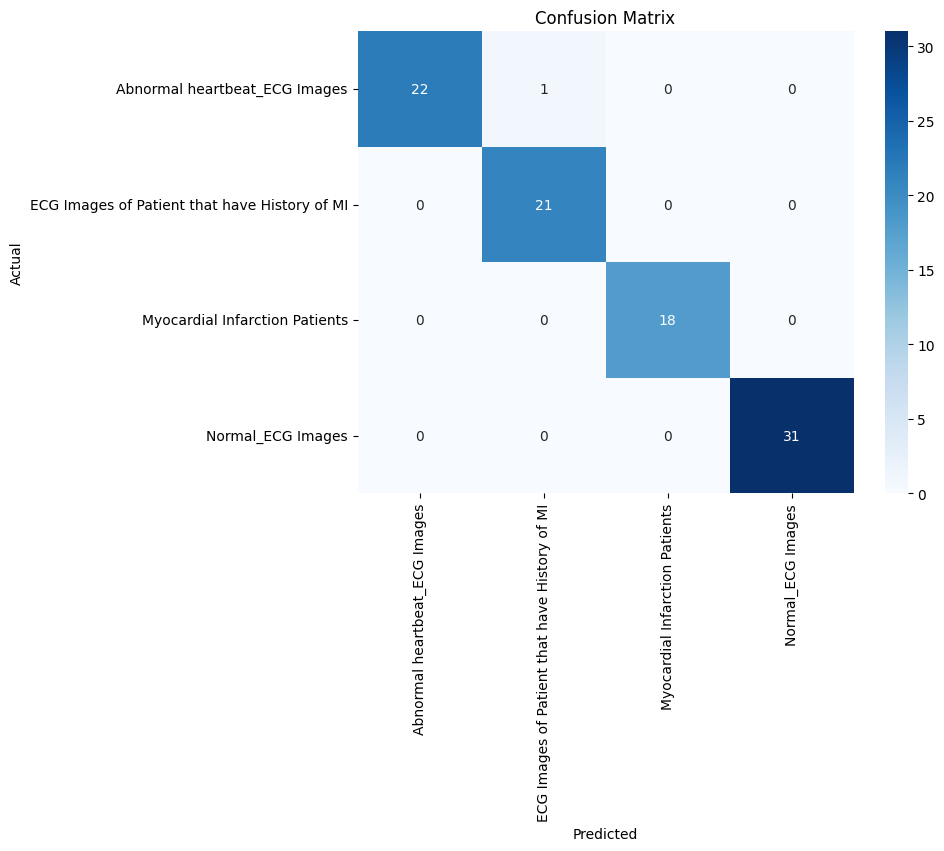

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [93]:
#Test Function

def test_model(model, test_loader, criterion, device='cuda'):
    model.eval()
    test_cost = 0.0
    test_correct = 0
    N_test = len(test_loader.dataset)
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss = criterion(outputs, labels)
            
            test_cost += test_loss.item()
            _, yhat = outputs.max(1)
            test_correct += (yhat == labels).sum().item()
    
    test_cost /= len(test_loader)
    test_acc = test_correct / N_test
    
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')


In [94]:
best_model = model
best_model.load_state_dict(torch.load('ECG_MFF_best.pt'))
test_model(best_model, test_loader, criterion)


Test Loss: 0.0854, Test Acc: 0.9785


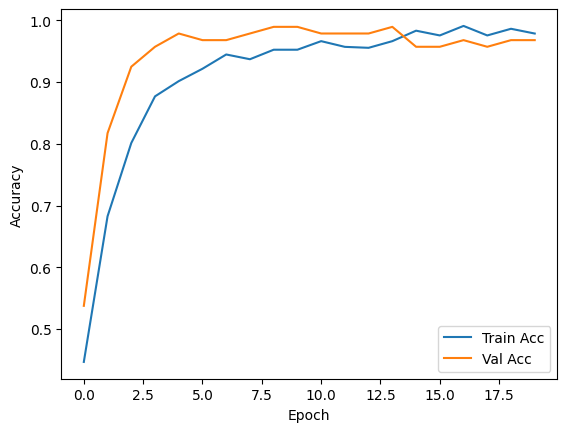

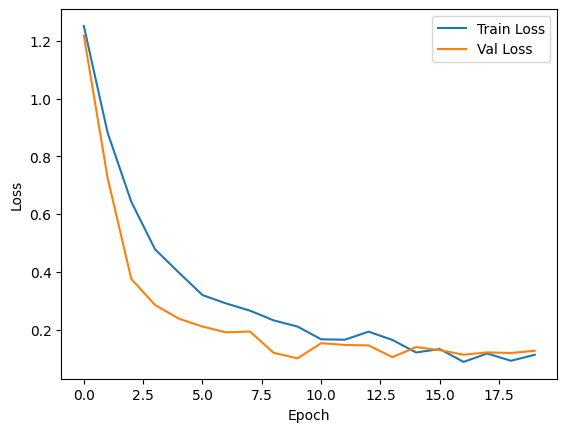

In [87]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(train_acc, label="Train Acc")
plt.plot(val_acc, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [90]:
from PIL import Image

def predict_image(img_path, model, transform, device):
    image = Image.open(img_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(image)
        pred = torch.argmax(output, dim=1).item()
    return classes[pred]

# Example:
new_image_path = "/kaggle/input/d/proggaparmita/ecg-image-dataset/ECG Image dataset for Myocardial Infarction Compli/Jay_Prakash_Maurya"
predicted_class = predict_image(new_image_path, ecg_mff_model, transform_val, device)
print("Predicted class:", predicted_class)


IsADirectoryError: [Errno 21] Is a directory: '/kaggle/input/d/proggaparmita/ecg-image-dataset/ECG Image dataset for Myocardial Infarction Compli/Jay_Prakash_Maurya'

**Efficientnetvit**

In [ ]:
import timm

# Load pre-trained EfficientViT from timm library (EfficientViT B0)
model = timm.create_model('efficientvit_b0', pretrained=True)  # Change to B1/B2 as needed
model = model.to(device)

num_classes = 4
# EfficientViT's final classifier layer is a `ClassifierHead`, not a simple fully connected layer.
# The `ClassifierHead` has a `fc` attribute, which is the actual fully connected layer.
model.classifier = nn.Sequential(
    nn.Linear(model.num_features, 512),  # You can adjust the intermediate layer size
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)  # Final output layer for your classes
)
model = model.to(device)

In [ ]:
# Training function with early stopping and loss plotting
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5):
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track accuracy and loss
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average training loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate average validation loss and accuracy
        val_loss /= len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)

        print(f"--> Epoch Number : {epoch + 1} | Training Loss : {round(train_loss, 4)} | Validation Loss : {round(val_loss, 4)} | Train Accuracy : {round(train_acc * 100, 2)}% | Validation Accuracy : {round(val_acc * 100, 2)}%")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset counter if validation loss improves
            print("Saving model....")
            torch.save(model.state_dict(), "efbv0.pt")  # Save the best model
        else:
            patience_counter += 1  # Increment counter if no improvement
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Plot training and validation loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


In [ ]:
# Adjusted Evaluate Function
def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
            _, preds = torch.max(outputs, 1)  # Get the predicted class

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert lists to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Evaluation metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='macro')

    # Handle multi-class AUC
    try:
        auc_roc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='weighted')
        print(f"AUC-ROC: {auc_roc:.4f}")
    except ValueError:
        print("AUC-ROC: Not applicable (possibly due to single class in test set)")

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model with early stopping and plot the loss curves
num_epochs = 100
patience = 10
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=patience)

In [ ]:
class_names = ['Abnormal heartbeat_ECG Images', 'Myocardial Infarction Patients' , 'ECG Images of Patient that have History of MI' , "Normal_ECG Images"]
evaluate_model(model, test_loader, class_names)

In [ ]:
#Test Function

def test_model(model, test_loader, criterion, device='cuda'):
    model.eval()
    test_cost = 0.0
    test_correct = 0
    N_test = len(test_loader.dataset)
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss = criterion(outputs, labels)
            
            test_cost += test_loss.item()
            _, yhat = outputs.max(1)
            test_correct += (yhat == labels).sum().item()
    
    test_cost /= len(test_loader)
    test_acc = test_correct / N_test
    
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
    from sklearn.metrics import classification_report
import torch

# Define class names properly
classes = [
    "Abnormal heartbeat ECG Images",
    "Myocardial Infarction Patients",
    "ECG Images of Patient with History of MI",
    "Normal ECG Images"
]

# Move model to eval mode and device
best_model.eval()
best_model.to(device)

# Lists to store true labels and predictions
y_pred = []
y_true = []

# Iterate over test data
for x, y in torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32):
    x = x.to(device)
    y = y.to(device)

    with torch.no_grad():
        outputs = best_model(x)
        _, yhat = outputs.max(1)

        y_pred.extend(yhat.cpu().numpy())
        y_true.extend(y.cpu().numpy())

# Generate classification report
report = classification_report(y_true, y_pred, target_names=classes)
print(report)


In [ ]:
#Test Function

def test_model(model, test_loader, criterion, device='cuda'):
    model.eval()
    test_cost = 0.0
    test_correct = 0
    N_test = len(test_loader.dataset)
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss = criterion(outputs, labels)
            
            test_cost += test_loss.item()
            _, yhat = outputs.max(1)
            test_correct += (yhat == labels).sum().item()
    
    test_cost /= len(test_loader)
    test_acc = test_correct / N_test
    
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

    
best_model = model
best_model.load_state_dict(torch.load('efbv0.pt'))
test_model(best_model, test_loader, criterion)



**Ensemble1**

In [ ]:
pip install timm


In [ ]:
checkpoint_path = '/kaggle/input/hybridcnntransformer/pytorch/default/1/HybridCNNTransformer.pt'

checkpoint = torch.load(checkpoint_path, map_location=device)


In [ ]:
import torch
import torch.nn as nn
import timm  # For pretrained EfficientNet backbone

class CrossAttention(nn.Module):
    def __init__(self, dim_q, dim_k, num_heads=4):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=dim_q, num_heads=num_heads)
    
    def forward(self, query, key, value):
        attn_output, _ = self.multihead_attn(query, key, value)
        return attn_output

class HybridCNNTransformer(nn.Module):
    def __init__(self, transformer_dim=128, num_heads=4, num_classes=4, dropout=0.3):
        super().__init__()

        # Pretrained EfficientNet backbone without classifier head
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0, global_pool='')  
        # EfficientNet-B0 outputs feature maps with 1280 channels

        self.adaptive_pool = nn.AdaptiveAvgPool2d((16,16))  # Fix spatial size to 16x16

        # Project backbone features channels (1280) to transformer_dim
        self.cnn_proj = nn.Linear(1280, transformer_dim)

        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(d_model=transformer_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)

        # Cross attention layers
        self.cross_attn_cnn_to_trans = CrossAttention(dim_q=transformer_dim, dim_k=transformer_dim, num_heads=num_heads)
        self.cross_attn_trans_to_cnn = CrossAttention(dim_q=transformer_dim, dim_k=transformer_dim, num_heads=num_heads)

        # Classifier head with dropout for regularization
        self.classifier = nn.Sequential(
            nn.Linear(transformer_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x: (batch, 3, H, W)
        cnn_feats = self.backbone(x)  # (batch, 1280, H', W')

        # Fix spatial size to 16x16
        cnn_feats = self.adaptive_pool(cnn_feats)  # (batch, 1280, 16, 16)

        batch_size, c, h, w = cnn_feats.shape
        cnn_feats = cnn_feats.view(batch_size, c, h * w)  # (batch, c, seq_len=256)

        cnn_feats = cnn_feats.permute(2, 0, 1)  # (seq_len=256, batch, c=1280)

        # Project to transformer dimension
        cnn_feats_proj = self.cnn_proj(cnn_feats)  # (seq_len, batch, transformer_dim)

        # Transformer encoding
        trans_feats = self.transformer_encoder(cnn_feats_proj)  # (seq_len, batch, transformer_dim)

        # Cross attention
        cross1 = self.cross_attn_cnn_to_trans(query=trans_feats, key=cnn_feats_proj, value=cnn_feats_proj)
        cross2 = self.cross_attn_trans_to_cnn(query=cnn_feats_proj, key=trans_feats, value=trans_feats)

        fused = cross1 + cross2  # (seq_len, batch, transformer_dim)

        # Global average pooling over sequence length dimension
        pooled = fused.mean(dim=0)  # (batch, transformer_dim)

        logits = self.classifier(pooled)  # (batch, num_classes)
        return logits


# === Instantiate model with 4 classes ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_hybrid = HybridCNNTransformer(num_classes=4).to(device)

# === Load checkpoint but skip classifier weights to avoid size mismatch ===
checkpoint_path = '/kaggle/input/hybridcnntransformer/pytorch/default/1/HybridCNNTransformer.pt'  # your checkpoint file

checkpoint = torch.load(checkpoint_path, map_location=device)
model_state_dict = model_hybrid.state_dict()

# Filter out classifier weights (prefix 'classifier.')
filtered_checkpoint = {k: v for k, v in checkpoint.items() if not k.startswith('classifier.')}

# Update model weights
model_state_dict.update(filtered_checkpoint)
model_hybrid.load_state_dict(model_state_dict)

print("Model loaded (classifier weights skipped). Ready for training or inference.")


In [ ]:
# Training function with early stopping and loss plotting
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5):
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track accuracy and loss
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average training loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate average validation loss and accuracy
        val_loss /= len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)

        print(f"--> Epoch Number : {epoch + 1} | Training Loss : {round(train_loss, 4)} | Validation Loss : {round(val_loss, 4)} | Train Accuracy : {round(train_acc * 100, 2)}% | Validation Accuracy : {round(val_acc * 100, 2)}%")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset counter if validation loss improves
            print("Saving model....")
            torch.save(model.state_dict(), "HybridCNNTransformer.pt")  # Save the best model
        else:
            patience_counter += 1  # Increment counter if no improvement
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Plot training and validation loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm  # For pretrained EfficientNet backbone

class CrossAttention(nn.Module):
    def __init__(self, dim_q, dim_k, num_heads=4):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=dim_q, num_heads=num_heads)
    
    def forward(self, query, key, value):
        attn_output, _ = self.multihead_attn(query, key, value)
        return attn_output

class HybridCNNTransformer(nn.Module):
    def __init__(self, transformer_dim=128, num_heads=4, num_classes=5, dropout=0.3):
        super().__init__()

        # Pretrained EfficientNet backbone without classifier head
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0, global_pool='')  
        # EfficientNet-B0 outputs feature maps with 1280 channels

        self.adaptive_pool = nn.AdaptiveAvgPool2d((16,16))  # Fix spatial size to 16x16

        # Project backbone features channels (1280) to transformer_dim
        self.cnn_proj = nn.Linear(1280, transformer_dim)

        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(d_model=transformer_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)

        # Cross attention layers
        self.cross_attn_cnn_to_trans = CrossAttention(dim_q=transformer_dim, dim_k=transformer_dim, num_heads=num_heads)
        self.cross_attn_trans_to_cnn = CrossAttention(dim_q=transformer_dim, dim_k=transformer_dim, num_heads=num_heads)

        # Classifier head with dropout for regularization
        self.classifier = nn.Sequential(
            nn.Linear(transformer_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x: (batch, 3, H, W)
        cnn_feats = self.backbone(x)  # (batch, 1280, H', W'), variable spatial dims depending on EfficientNet

        # Fix spatial size to 16x16
        cnn_feats = self.adaptive_pool(cnn_feats)  # (batch, 1280, 16, 16)

        batch_size, c, h, w = cnn_feats.shape
        cnn_feats = cnn_feats.view(batch_size, c, h * w)  # (batch, c, seq_len=256)

        cnn_feats = cnn_feats.permute(2, 0, 1)  # (seq_len=256, batch, c=1280)

        # Project to transformer dimension
        cnn_feats_proj = self.cnn_proj(cnn_feats)  # (seq_len, batch, transformer_dim)

        # Transformer encoding
        trans_feats = self.transformer_encoder(cnn_feats_proj)  # (seq_len, batch, transformer_dim)

        # Cross attention
        cross1 = self.cross_attn_cnn_to_trans(query=trans_feats, key=cnn_feats_proj, value=cnn_feats_proj)
        cross2 = self.cross_attn_trans_to_cnn(query=cnn_feats_proj, key=trans_feats, value=trans_feats)

        fused = cross1 + cross2  # (seq_len, batch, transformer_dim)

        # Global average pooling over sequence length dimension
        pooled = fused.mean(dim=0)  # (batch, transformer_dim)

        logits = self.classifier(pooled)  # (batch, num_classes)
        return logits


In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model with early stopping and plot the loss curves
num_epochs = 50
patience = 10
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=patience)

In [ ]:
class_names = ['Abnormal heartbeat_ECG Images', 'Myocardial Infarction Patients' , 'ECG Images of Patient that have History of MI' , "Normal_ECG Images"]
evaluate_model(model, test_loader, class_names)

In [ ]:
#Test Function

def test_model(model, test_loader, criterion, device='cuda'):
    model.eval()
    test_cost = 0.0
    test_correct = 0
    N_test = len(test_loader.dataset)
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss = criterion(outputs, labels)
            
            test_cost += test_loss.item()
            _, yhat = outputs.max(1)
            test_correct += (yhat == labels).sum().item()
    
    test_cost /= len(test_loader)
    test_acc = test_correct / N_test
    
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
    from sklearn.metrics import classification_report
import torch

# Define class names properly
classes = [
    "Abnormal heartbeat ECG Images",
    "Myocardial Infarction Patients",
    "ECG Images of Patient with History of MI",
    "Normal ECG Images"
]

# Move model to eval mode and device
best_model.eval()
best_model.to(device)

# Lists to store true labels and predictions
y_pred = []
y_true = []

# Iterate over test data
for x, y in torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32):
    x = x.to(device)
    y = y.to(device)

    with torch.no_grad():
        outputs = best_model(x)
        _, yhat = outputs.max(1)

        y_pred.extend(yhat.cpu().numpy())
        y_true.extend(y.cpu().numpy())

# Generate classification report
report = classification_report(y_true, y_pred, target_names=classes)
print(report)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Instantiate your models ===
model_densenet = ModifiedDenseNet201(num_classes=5).to(device)
model_hybrid = HybridCNNTransformer(num_classes=5).to(device)
fusion_model = FeatureFusionModel(model_densenet, model_hybrid, num_classes=5).to(device)

# === Loss & Optimizer ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fusion_model.parameters(), lr=1e-4)
num_epochs = 50

# === Lists to store training history ===
train_cost_list = []
val_cost_list = []
train_acc_list = []
val_acc_list = []

# === Training loop ===
for epoch in range(num_epochs):
    fusion_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = fusion_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    train_cost_list.append(train_loss)
    train_acc_list.append(train_acc)

    # === Validation ===
    fusion_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            images, labels = images.to(device), labels.to(device)
            outputs = fusion_model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_cost_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")

# === Plot Loss & Accuracy Curves ===
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_cost_list, label="Train Loss")
plt.plot(val_cost_list, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc_list, label="Train Acc")
plt.plot(val_acc_list, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.show()

# === Final Evaluation on Validation/Test Set ===
fusion_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:  # change to test_loader if needed
        images, labels = images.to(device), labels.to(device)
        outputs = fusion_model(images)
        preds = outputs.argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# === Classification Report ===
classes = [    "Abnormal heartbeat ECG Images",
    "Myocardial Infarction Patients",
    "ECG Images of Patient with History of MI",
    "Normal ECG Images"]  # Change to your labels
print(classification_report(y_true, y_pred, target_names=classes))

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [ ]:
# === Save the trained model ===
model_save_path = "fusion_model.pth"

torch.save({
    'model_state_dict': fusion_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': num_epochs,
    'train_loss': train_cost_list,
    'val_loss': val_cost_list,
    'train_acc': train_acc_list,
    'val_acc': val_acc_list
}, model_save_path)

print(f"Model saved to {model_save_path}")


In [ ]:
class_names = ['Abnormal heartbeat_ECG Images', 'Myocardial Infarction Patients' , 'ECG Images of Patient that have History of MI' , "Normal_ECG Images"]
evaluate_model(model, test_loader, class_names)

In [ ]:
pip install grad-cam


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=4)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Instantiate your models ===
model_densenet = ModifiedDenseNet201(num_classes=5).to(device)
model_hybrid = HybridCNNTransformer(num_classes=5).to(device)
fusion_model = FeatureFusionModel(model_densenet, model_hybrid, num_classes=5).to(device)

# === Loss & Optimizer ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fusion_model.parameters(), lr=1e-4)
num_epochs = 50

# === Mixed precision scaler ===
scaler = torch.cuda.amp.GradScaler()

# === Lists to store training history ===
train_cost_list = []
val_cost_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(num_epochs):
    fusion_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = fusion_model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    train_cost_list.append(train_loss)
    train_acc_list.append(train_acc)

    # === Validation ===
    fusion_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            images, labels = images.to(device), labels.to(device)
            with torch.cuda.amp.autocast():
                outputs = fusion_model(images)
                loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_cost_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")

# === Plot Loss & Accuracy Curves ===
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_cost_list, label="Train Loss")
plt.plot(val_cost_list, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc_list, label="Train Acc")
plt.plot(val_acc_list, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.show()

# === Final Evaluation on Validation/Test Set ===
fusion_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:  # change to test_loader if needed
        images, labels = images.to(device), labels.to(device)
        with torch.cuda.amp.autocast():
            outputs = fusion_model(images)
        preds = outputs.argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# === Classification Report ===
classes = [
    "Abnormal heartbeat ECG Images",
    "Myocardial Infarction Patients",
    "ECG Images of Patient with History of MI",
    "Normal ECG Images"
]  # Change to your labels
print(classification_report(y_true, y_pred, target_names=classes))

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# === Save the trained model ===
model_save_path = "fusion_model_ecg_mixed_precision.pth"
torch.save({
    'model_state_dict': fusion_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': num_epochs,
    'train_loss': train_cost_list,
    'val_loss': val_cost_list,
    'train_acc': train_acc_list,
    'val_acc': val_acc_list
}, model_save_path)

print(f"Model saved to {model_save_path}")
